Segment 1: Risk Stratification (Classification).


In [4]:
import pandas as pd
import os

def load_mimic_tables(base_path="C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data"):
    patients = pd.read_csv(os.path.join(base_path, "PATIENTS.csv"))
    admissions = pd.read_csv(os.path.join(base_path, "ADMISSIONS.csv"))
    diagnoses = pd.read_csv(os.path.join(base_path, "DIAGNOSES_ICD.csv"))
    diag_dict = pd.read_csv(os.path.join(base_path, "D_ICD_DIAGNOSES.csv"))
    labs = pd.read_csv(os.path.join(base_path, "LABEVENTS.csv"))
    lab_dict = pd.read_csv(os.path.join(base_path, "D_LABITEMS.csv"))
    return patients, admissions, diagnoses, diag_dict, labs, lab_dict


In [5]:
import pandas as pd

def build_classification_dataset(patients, admissions, diagnoses, diag_dict, labs, lab_dict):
    # --- Standardize column names ---
    patients.columns = patients.columns.str.lower()
    admissions.columns = admissions.columns.str.lower()
    diagnoses.columns = diagnoses.columns.str.lower()
    diag_dict.columns = diag_dict.columns.str.lower()
    labs.columns = labs.columns.str.lower()
    lab_dict.columns = lab_dict.columns.str.lower()

    # --- Robust renaming in case lowercase didn't apply properly ---
    if "SUBJECT_ID" in patients.columns:
        patients = patients.rename(columns={"SUBJECT_ID": "subject_id"})
    if "SUBJECT_ID" in admissions.columns:
        admissions = admissions.rename(columns={"SUBJECT_ID": "subject_id"})
    if "SUBJECT_ID" in diagnoses.columns:
        diagnoses = diagnoses.rename(columns={"SUBJECT_ID": "subject_id"})
    if "SUBJECT_ID" in labs.columns:
        labs = labs.rename(columns={"SUBJECT_ID": "subject_id"})

    # --- Debugging: show first 10 column names ---
    print("Patients columns:", patients.columns.tolist()[:10])
    print("Admissions columns:", admissions.columns.tolist()[:10])
    print("Diagnoses columns:", diagnoses.columns.tolist()[:10])
    print("Labs columns:", labs.columns.tolist()[:10])

    # --- Merge admissions + patients ---
    df = admissions.merge(patients, on="subject_id", how="left")

    # --- Target variable: diabetes flag (ICD9 250.xx) ---
    diagnoses = diagnoses.merge(diag_dict, on="icd9_code", how="left")
    diagnoses["is_diabetes"] = diagnoses["icd9_code"].astype(str).str.startswith("250").astype(int)
    diabetes_flags = diagnoses.groupby("subject_id")["is_diabetes"].max().reset_index()

    df = df.merge(diabetes_flags, on="subject_id", how="left")
    df["is_diabetes"] = df["is_diabetes"].fillna(0).astype(int)

    # --- Lab features (subset of common labs) ---
    labs = labs.merge(lab_dict, on="itemid", how="left")
    selected_labs = ["GLUCOSE", "CREATININE", "HEMOGLOBIN", "POTASSIUM", "SODIUM"]
    labs = labs[labs["label"].isin(selected_labs)]

    lab_features = (
        labs.groupby(["subject_id", "label"])["valuenum"]
        .agg(["mean", "min", "max"])
        .reset_index()
    )

    lab_features = lab_features.pivot(index="subject_id", columns="label", values="mean").reset_index()
    lab_features.columns = [str(col).lower() for col in lab_features.columns]

    df = df.merge(lab_features, on="subject_id", how="left")

    # --- Feature / Target split ---
    features = [c for c in df.columns if c not in ["is_diabetes"]]
    target = "is_diabetes"

    return df[features], df[target]


In [6]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models

def train_logistic(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def train_xgb(X_train, y_train):
    model = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric="logloss")
    model.fit(X_train, y_train)
    return model

def build_nn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
    return model

def evaluate(model, X_test, y_test, keras=False):
    if keras:
        y_pred_proba = model.predict(X_test).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
    else:
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_pred_proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_pred_proba)
    }


In [7]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Paths to uploaded CSVs
DATA_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data"

PATIENTS = os.path.join(DATA_DIR, "PATIENTS.csv")
ADMISSIONS = os.path.join(DATA_DIR, "ADMISSIONS.csv")
DIAGNOSES = os.path.join(DATA_DIR, "DIAGNOSES_ICD.csv")
D_ICD = os.path.join(DATA_DIR, "D_ICD_DIAGNOSES.csv")
LABS = os.path.join(DATA_DIR, "LABEVENTS.csv")
D_LABS = os.path.join(DATA_DIR, "D_LABITEMS.csv")

MODEL_DIR = "models/classification"
os.makedirs(MODEL_DIR, exist_ok=True)


# ----------------- Feature Builder -----------------
def build_classification_dataset(patients, admissions, diagnoses, diag_dict, labs, lab_dict):
    # Lowercase all column names
    for df in [patients, admissions, diagnoses, diag_dict, labs, lab_dict]:
        df.columns = df.columns.str.lower()

    # Merge admissions + patients
    df = admissions.merge(patients, on="subject_id", how="left")

    # Diabetes flag from diagnoses
    diagnoses = diagnoses.merge(diag_dict, on="icd9_code", how="left")
    diagnoses["is_diabetes"] = diagnoses["icd9_code"].astype(str).str.startswith("250").astype(int)
    diabetes_flags = diagnoses.groupby("subject_id")["is_diabetes"].max().reset_index()
    df = df.merge(diabetes_flags, on="subject_id", how="left")
    df["is_diabetes"] = df["is_diabetes"].fillna(0).astype(int)

    # Lab features (subset of common ones)
    labs = labs.merge(lab_dict, on="itemid", how="left")
    selected_labs = ["GLUCOSE", "CREATININE", "HEMOGLOBIN", "POTASSIUM", "SODIUM"]
    labs = labs[labs["label"].isin(selected_labs)]

    lab_features = (
        labs.groupby(["subject_id", "label"])["valuenum"]
        .agg(["mean", "min", "max"])
        .reset_index()
    )
    lab_features = lab_features.pivot(index="subject_id", columns="label", values="mean").reset_index()
    lab_features.columns = [str(col).lower() for col in lab_features.columns]

    df = df.merge(lab_features, on="subject_id", how="left")

    features = [c for c in df.columns if c not in ["is_diabetes"]]
    target = "is_diabetes"
    return df[features], df[target]


# ----------------- Models -----------------
def train_logistic(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def train_xgb(X_train, y_train):
    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train)
    return model

def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_dim=input_dim),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def evaluate(model, X_test, y_test, keras=False):
    if keras:
        preds = (model.predict(X_test) > 0.5).astype(int).flatten()
    else:
        preds = model.predict(X_test)
    return accuracy_score(y_test, preds)


# ----------------- Main -----------------
def main():
    # Load raw tables
    patients = pd.read_csv(PATIENTS)
    admissions = pd.read_csv(ADMISSIONS)
    diagnoses = pd.read_csv(DIAGNOSES)
    diag_dict = pd.read_csv(D_ICD)
    labs = pd.read_csv(LABS)
    lab_dict = pd.read_csv(D_LABS)

    # Build dataset
    X, y = build_classification_dataset(patients, admissions, diagnoses, diag_dict, labs, lab_dict)

    # Handle missing values (numeric only)
    X_numeric = X.select_dtypes(include=["number"])
    X_numeric = X_numeric.fillna(X_numeric.median())

    # Keep non-numeric columns separate
    X_non_numeric = X.select_dtypes(exclude=["number"])

    # Combine back
    X = pd.concat([X_numeric, X_non_numeric], axis=1)

    # Scale only numeric columns
    scaler = StandardScaler()
    X_scaled_numeric = scaler.fit_transform(X_numeric)

    # Replace numeric part with scaled values
    X_scaled = pd.DataFrame(X_scaled_numeric, columns=X_numeric.columns, index=X.index)

    # Add back non-numeric features (optional: encode later)
    X_scaled = pd.concat([X_scaled, X_non_numeric.reset_index(drop=True)], axis=1)


    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.select_dtypes(include=["float64", "int64"]))

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Logistic Regression
    lr = train_logistic(X_train, y_train)
    joblib.dump(lr, os.path.join(MODEL_DIR, "logistic.pkl"))
    print("LR:", evaluate(lr, X_test, y_test))

    # XGBoost
    xgb_model = train_xgb(X_train, y_train)
    joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgb.pkl"))
    print("XGB:", evaluate(xgb_model, X_test, y_test))

    # Neural Net
    nn = build_nn(X_train.shape[1])
    nn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
    nn.save(os.path.join(MODEL_DIR, "nn.h5"))
    print("NN:", evaluate(nn, X_test, y_test, keras=True))


if __name__ == "__main__":
    main()



LR: 0.7634533488192025
XGB: 0.7619047619047619


c:\Users\Bernietta\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:22:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Bernietta\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7624 - loss: 0.5392 - val_accuracy: 0.7619 - val_loss: 0.5237
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7630 - loss: 0.5327 - val_accuracy: 0.7585 - val_loss: 0.5248
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7637 - loss: 0.5313 - val_accuracy: 0.7619 - val_loss: 0.5299
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7642 - loss: 0.5312 - val_accuracy: 0.7619 - val_loss: 0.5259
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7637 - loss: 0.5310 - val_accuracy: 0.7619 - val_loss: 0.5240
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7637 - loss: 0.5304 - val_accuracy: 0.7609 - val_loss: 0.5244
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7634 - loss: 0.5304 - val_accuracy: 0.7619 - val_loss: 0.5260
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7636 - loss: 0.5300 - val_accuracy: 0.

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN: 0.7638404955478126


In [8]:
!pip install joblib


In [ ]:
!pip show joblib


^C


Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: C:\Users\Bernietta\anaconda3\Lib\site-packages
Requires: 
Required-by: hdbscan, imbalanced-learn, mlxtend, nltk, sacremoses, scikit-learn


Segment 2: Length of Stay Prediction (Regression).


In [ ]:
import pandas as pd
import numpy as np
import os

def load_and_build_los(base_path="C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data"):
    admissions = pd.read_csv(os.path.join(base_path, "ADMISSIONS.csv"))
    patients = pd.read_csv(os.path.join(base_path, "PATIENTS.csv"))

    admissions.columns = admissions.columns.str.strip().str.upper()
    patients.columns = patients.columns.str.strip().str.upper()

    df = admissions.merge(patients, on="SUBJECT_ID", how="left")

    df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"], errors="coerce")
    df["DISCHTIME"] = pd.to_datetime(df["DISCHTIME"], errors="coerce")
    df["DOB"] = pd.to_datetime(df["DOB"], errors="coerce")

    # LOS in days
    df["los_days"] = (df["DISCHTIME"] - df["ADMITTIME"]).dt.total_seconds() / (3600 * 24)
    df = df[df["los_days"] > 0]

    # ✅ Safe age calculation
    df["age"] = df["ADMITTIME"].dt.year - df["DOB"].dt.year
    df["age"] = df["age"] - (
        (df["ADMITTIME"].dt.month < df["DOB"].dt.month) |
        ((df["ADMITTIME"].dt.month == df["DOB"].dt.month) & (df["ADMITTIME"].dt.day < df["DOB"].dt.day))
    ).astype(int)

    df.loc[df["age"] < 0, "age"] = np.nan
    df["age"] = df["age"].clip(0, 120)
    df = df.dropna(subset=["age"])

    # Encode gender
    df["gender"] = df["GENDER"].map({"M": 0, "F": 1})

    features = ["age", "gender", "ETHNICITY", "ADMISSION_TYPE"]
    target = "los_days"

    return df[features], df[target]



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def train_linear(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_rf(X_train, y_train):
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    return model

def build_lstm(input_shape):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def evaluate_regression(model, X_test, y_test, keras=False):
    if keras:
        y_pred = model.predict(X_test).ravel()
    else:
        y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


In [ ]:
import pandas as pd
admissions = pd.read_csv("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/ADMISSIONS.csv", nrows=5)
patients = pd.read_csv("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/PATIENTS.csv", nrows=5)

print("Admissions columns:", admissions.columns.tolist())
print("Patients columns:", patients.columns.tolist())


Admissions columns: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
Patients columns: ['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG']


In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from src.regression.preprocess_regression import load_and_build_los
from src.regression.models_regression import train_linear, train_rf, build_lstm, evaluate_regression

MODEL_DIR = "models/regression"
os.makedirs(MODEL_DIR, exist_ok=True)

def main():
    X, y = load_and_build_los()

    # Identify feature types
    numeric_feats = ["age"]
    categorical_feats = ["gender", "ETHNICITY", "ADMISSION_TYPE"]


    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_feats)
    ])

    X_proc = preprocessor.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)

    # Linear Regression
    lr = train_linear(X_train, y_train)
    joblib.dump(lr, os.path.join(MODEL_DIR, "linear.pkl"))
    print("Linear:", evaluate_regression(lr, X_test, y_test))

    # Random Forest
    rf = train_rf(X_train, y_train)
    joblib.dump(rf, os.path.join(MODEL_DIR, "rf.pkl"))
    print("RandomForest:", evaluate_regression(rf, X_test, y_test))

    # LSTM (toy example: reshape features as sequences)
    import numpy as np
    X_train_seq = np.expand_dims(X_train.toarray() if hasattr(X_train, "toarray") else X_train, axis=1)
    X_test_seq = np.expand_dims(X_test.toarray() if hasattr(X_test, "toarray") else X_test, axis=1)

    lstm = build_lstm(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    lstm.fit(X_train_seq, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
    lstm.save(os.path.join(MODEL_DIR, "lstm.h5"))
    print("LSTM:", evaluate_regression(lstm, X_test_seq, y_test, keras=True))

    lstm.save(os.path.join(MODEL_DIR, "lstm.h5"))
    print("✅ Saved LSTM model")
    print("LSTM metrics:", evaluate_regression(lstm, X_test_seq, y_test, keras=True))

if __name__ == "__main__":
    main()


c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\regression\preprocess_regression.py:14: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"], errors="coerce")
c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\regression\preprocess_regression.py:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DISCHTIME"] = pd.to_datetime(df["DISCHTIME"], errors="coerce")
c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\regression\preprocess_regression.py:16: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DOB"] = pd.to_datetime(df["DOB"], errors="coer

Linear: {'MAE': 8.760478235042822, 'RMSE': 14.65999966635745, 'R2': -2.0412850056938936e-06}
RandomForest: {'MAE': 8.977049004989412, 'RMSE': 14.915993417391464, 'R2': -0.0352311508043186}
Epoch 1/10


c:\Users\Bernietta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 235.1203 - mae: 8.6153 - val_loss: 219.3771 - val_mae: 8.2431
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 191.1049 - mae: 8.2702 - val_loss: 218.6283 - val_mae: 8.5365
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 190.8669 - mae: 8.3592 - val_loss: 218.6227 - val_mae: 8.5707
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.7338 - mae: 8.3504 - val_loss: 218.6665 - val_mae: 8.5428
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.5824 - mae: 8.4004 - val_loss: 218.9150 - val_mae: 8.4295
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.4638 - mae: 8.3461 - val_loss: 218.8217 - val_mae: 8.4625
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.3797 - mae: 8.3497 - val_loss: 218.6693 - val_mae: 8.5862
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.2655 - mae: 8.3457 - val_loss: 218.6464 - val_mae: 8.6383
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


LSTM: {'MAE': 8.800519476569082, 'RMSE': 14.639189543857608, 'R2': 0.002834983988986961}
✅ Saved LSTM model
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM metrics: {'MAE': 8.800519476569082, 'RMSE': 14.639189543857608, 'R2': 0.002834983988986961}


In [ ]:
from src.regression.preprocess_regression import load_and_build_los


Segment 3: Patient Segmentation (Clustering).

In [ ]:
import os
import pandas as pd

def load_and_build_clustering(base_path="C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data"):
    admissions = pd.read_csv(os.path.join(base_path, "ADMISSIONS.csv"))
    patients = pd.read_csv(os.path.join(base_path, "PATIENTS.csv"))
    diagnoses = pd.read_csv(os.path.join(base_path, "DIAGNOSES_ICD.csv"))
    labs = pd.read_csv(os.path.join(base_path, "LABEVENTS.csv"))

    # 🔑 Normalize column names to uppercase
    admissions.columns = admissions.columns.str.strip().str.upper()
    patients.columns = patients.columns.str.strip().str.upper()
    diagnoses.columns = diagnoses.columns.str.strip().str.upper()
    labs.columns = labs.columns.str.strip().str.upper()

    print("Admissions cols:", admissions.columns.tolist())  # 👈 debug
    print("Patients cols:", patients.columns.tolist())      # 👈 debug

    # ✅ Always merge on uppercase SUBJECT_ID
    df = admissions.merge(patients, on="SUBJECT_ID", how="left")

    # Age
    df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"], errors="coerce")
    df["DOB"] = pd.to_datetime(df["DOB"], errors="coerce")
    df["age"] = df["ADMITTIME"].dt.year - df["DOB"].dt.year
    df["age"] = df["age"].clip(0, 120)

    # Gender
    df["gender"] = df["GENDER"].map({"M": 0, "F": 1})

    features = ["age", "gender"]
    X = df[features].fillna(0)

    return X, df


In [ ]:

!pip install hdbscan

In [ ]:
from sklearn.cluster import KMeans
import hdbscan
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def run_kmeans(X, n_clusters=4):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X)
    return model, labels

def run_hdbscan(X, min_cluster_size=50):
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = model.fit_predict(X)
    return model, labels

def plot_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(6,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=10)
    plt.title(title)
    plt.show()


Admissions cols: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
Patients cols: ['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG']


c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\clustering\preprocess_clustering.py:23: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"], errors="coerce")
c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\clustering\preprocess_clustering.py:24: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DOB"] = pd.to_datetime(df["DOB"], errors="coerce")


KMeans cluster sizes:
 cluster_kmeans
0    5199
1    3736
2    2071
3    1905
Name: count, dtype: int64


c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN cluster sizes:
 cluster_hdbscan
 0     1682
 1     1563
-1      401
 53     163
 49     157
       ... 
 92      57
 83      56
 94      53
 93      52
 29      52
Name: count, Length: 99, dtype: int64
✅ Saved patient clusters to models/clustering/patient_clusters.csv


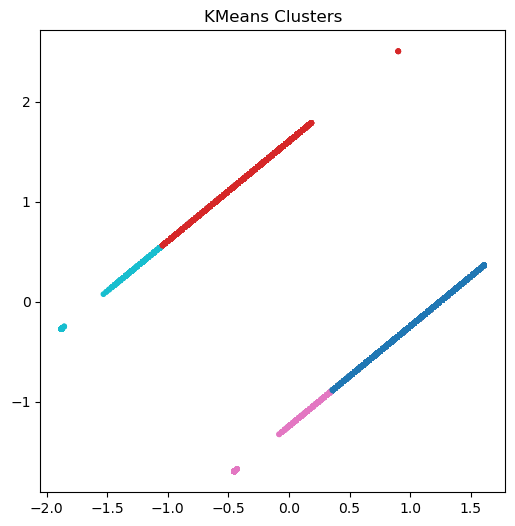

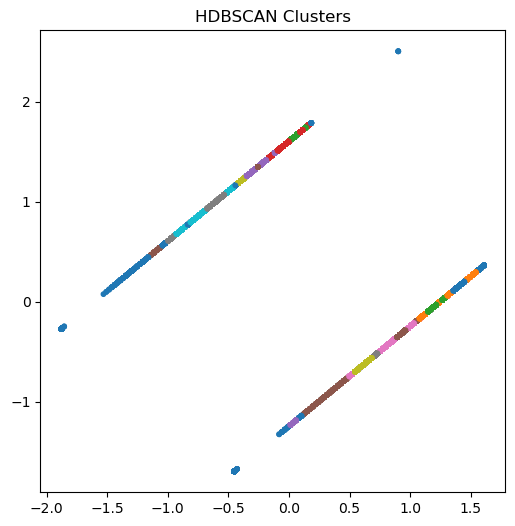

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

from src.clustering.preprocess_clustering import load_and_build_clustering
from src.clustering.models_clustering import run_kmeans, run_hdbscan, plot_clusters

MODEL_DIR = "models/clustering"
os.makedirs(MODEL_DIR, exist_ok=True)

def main():
    X, df_full = load_and_build_clustering()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ---- KMeans ----
    kmeans, labels_kmeans = run_kmeans(X_scaled, n_clusters=4)
    df_full["cluster_kmeans"] = labels_kmeans
    print("KMeans cluster sizes:\n", df_full["cluster_kmeans"].value_counts())

    # ---- HDBSCAN ----
    hdbscan_model, labels_hdb = run_hdbscan(X_scaled, min_cluster_size=50)
    df_full["cluster_hdbscan"] = labels_hdb
    print("HDBSCAN cluster sizes:\n", df_full["cluster_hdbscan"].value_counts())

    # ---- Save results ----
    df_full.to_csv(os.path.join(MODEL_DIR, "patient_clusters.csv"), index=False)
    print("✅ Saved patient clusters to models/clustering/patient_clusters.csv")

    # ---- Plot clusters ----
    plot_clusters(X_scaled, labels_kmeans, title="KMeans Clusters")
    plot_clusters(X_scaled, labels_hdb, title="HDBSCAN Clusters")

if __name__ == "__main__":
    main()


Segment 4: Medical Associations (Association Rules Mining).

In [ ]:
import pandas as pd
import os

def load_and_prepare_association(base_path="C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data"):
    # ---- Load datasets ----
    diagnoses = pd.read_csv(os.path.join(base_path, "DIAGNOSES_ICD.csv"))
    diag_dict = pd.read_csv(os.path.join(base_path, "D_ICD_DIAGNOSES.csv"))
    procedures = pd.read_csv(os.path.join(base_path, "PROCEDURES_ICD.csv"))
    prescriptions = pd.read_csv(os.path.join(base_path, "PRESCRIPTIONS.csv"))

    # 🔑 Normalize column names to uppercase for consistency
    diagnoses.columns = diagnoses.columns.str.strip().str.upper()
    diag_dict.columns = diag_dict.columns.str.strip().str.upper()
    procedures.columns = procedures.columns.str.strip().str.upper()
    prescriptions.columns = prescriptions.columns.str.strip().str.upper()

    # ---- Map ICD9 codes to human-readable text ----
    if "ICD9_CODE" in diagnoses.columns and "ICD9_CODE" in diag_dict.columns:
        diagnoses = diagnoses.merge(diag_dict, on="ICD9_CODE", how="left")

    # ---- Build transactions (per admission) ----
    diag_tx = (
        diagnoses.groupby("HADM_ID")["LONG_TITLE"]
        .apply(list)
        .reset_index()
    )
    proc_tx = (
        procedures.groupby("HADM_ID")["ICD9_CODE"]
        .apply(list)
        .reset_index()
    )
    drug_tx = (
        prescriptions.groupby("HADM_ID")["DRUG"]
        .apply(lambda x: list(set(x)))
        .reset_index()
    )

    # ---- Merge into single transactions ----
    df = diag_tx.merge(proc_tx, on="HADM_ID", how="outer").merge(drug_tx, on="HADM_ID", how="outer")

    # Fill NaNs and convert lists properly
    df = df.fillna("").astype(str)

    # ---- Build final "items" list ----
    df["items"] = df[["LONG_TITLE", "ICD9_CODE", "DRUG"]].apply(
        lambda row: [x for x in row if x not in ["", "nan", "NaT"]], axis=1
    )

    return df[["HADM_ID", "items"]]


In [ ]:
!pip install mlxtend pandas


In [ ]:
# src/association/run_association.py
import os
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from src.association.preprocess_association import load_and_prepare_association

MODEL_DIR = os.path.join("models", "association")
os.makedirs(MODEL_DIR, exist_ok=True)

def main():
    # 1. Load data
    df = load_and_prepare_association()
    transactions = df["items"].tolist()

    if not transactions or all(len(t)==0 for t in transactions):
        print("⚠️ No transactions found. Check DIAGNOSES_ICD / PROCEDURES_ICD / PRESCRIPTIONS CSVs.")
        return

    # 2. One-hot encode
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # 3. Run Apriori
    frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)  # lowered min_support
    if frequent_itemsets.empty:
        print("⚠️ No frequent itemsets found. Try lowering min_support further.")
    else:
        frequent_itemsets.to_csv(os.path.join(MODEL_DIR, "frequent_itemsets.csv"), index=False)
        print(f"✅ Saved frequent_itemsets.csv with {len(frequent_itemsets)} rows")

    # 4. Generate rules
    if not frequent_itemsets.empty:
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
        if rules.empty:
            print("⚠️ No association rules found with lift >= 1.0")
        else:
            rules_sorted = rules.sort_values(by="lift", ascending=False)
            rules_sorted.to_csv(os.path.join(MODEL_DIR, "association_rules.csv"), index=False)
            print(f"✅ Saved association_rules.csv with {len(rules_sorted)} rows")
            print(rules_sorted.head(10))

if __name__ == "__main__":
    main()


c:\Users\Bernietta\OneDrive\guvi\guvi_project\main_project\src\association\preprocess_association.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv(os.path.join(base_path, "PRESCRIPTIONS.csv"))


✅ Saved frequent_itemsets.csv with 11 rows
⚠️ No association rules found with lift >= 1.0


Segment 5 time: Imaging Diagnostics (CNN on chest X-rays)


In [ ]:

!pip install tensorflow scikit-learn matplotlib


In [ ]:
import tensorflow as tf
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 1000

def load_datasets(data_dir=r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/images"):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Normalize
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds, test_ds


In [ ]:
import tensorflow as tf
import os
from src.imaging.preprocess_images import load_datasets

MODEL_DIR = "models/imaging"
os.makedirs(MODEL_DIR, exist_ok=True)

def build_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def main():
    train_ds, val_ds, test_ds = load_datasets()

    model = build_cnn()
    history = model.fit(train_ds, validation_data=val_ds, epochs=10)

    # Save
    model.save(os.path.join(MODEL_DIR, "cnn_chestxray.h5"))
    print("✅ CNN model saved to models/imaging/cnn_chestxray.h5")

if __name__ == "__main__":
    main()


Found 5006 files belonging to 2 classes.
Found 20370 files belonging to 2 classes.
Found 8028 files belonging to 2 classes.
Epoch 1/10


c:\Users\Bernietta\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.5284 - loss: 0.8128 - val_accuracy: 0.5058 - val_loss: 0.7755
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - accuracy: 0.5551 - loss: 0.6845 - val_accuracy: 0.4084 - val_loss: 0.7326
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.5479 - loss: 0.6883 - val_accuracy: 0.4358 - val_loss: 0.7347
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.5849 - loss: 0.6751 - val_accuracy: 0.3861 - val_loss: 0.7653
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - accuracy: 0.5801 - loss: 0.6719 - val_accuracy: 0.4643 - val_loss: 0.9698
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.5939 - loss: 0.6657 - val_accuracy: 0.3960 - val_loss: 0.8892
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.5977 - loss: 0.6570 - val_accuracy: 0.4073 - val_loss: 0.8693
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.6211 - loss: 0.6397 - val_accuracy: 0.4532 - val_loss: 1.

✅ CNN model saved to models/imaging/cnn_chestxray.h5


In [ ]:
import tensorflow as tf
import os
from src.imaging.preprocess_images import load_datasets
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

MODEL_DIR = "models/imaging"

def main():
    _, _, test_ds = load_datasets()
    model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "cnn_chestxray.h5"))

    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    main()


Found 5006 files belonging to 2 classes.
Found 20370 files belonging to 2 classes.
Found 8028 files belonging to 2 classes.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

Segment 6: Sequence Modeling (RNN/LSTM for patient vitals)

In [ ]:
import pandas as pd
import numpy as np
import os

INPUT_FILE = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/human_vital_signs_dataset_2024.csv/human_vital_signs_dataset_2024.csv"
OUTPUT_FILE = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/timeseries/human_vital_signs_timeseries.csv"

def generate_time_series():
    df = pd.read_csv(INPUT_FILE)
    df = df.rename(columns={
        "Patient ID": "patient_id",
        "Timestamp": "time",
        "Heart Rate": "heart_rate",
        "Respiratory Rate": "respiratory_rate",
        "Body Temperature": "temperature",
        "Oxygen Saturation": "spo2",
        "Systolic Blood Pressure": "systolic_bp",
        "Diastolic Blood Pressure": "diastolic_bp"
    })

    all_records = []
    np.random.seed(42)

    for _, row in df.iterrows():
        patient_id = row["patient_id"]
        base_time = pd.to_datetime(row["time"])

        # Generate 20 readings per patient (every 5 minutes)
        for i in range(20):
            timestamp = base_time + pd.Timedelta(minutes=5 * i)
            rec = row.copy()
            rec["time"] = timestamp

            # add small physiological noise
            rec["heart_rate"] += np.random.normal(0, 3)
            rec["respiratory_rate"] += np.random.normal(0, 0.8)
            rec["temperature"] += np.random.normal(0, 0.1)
            rec["spo2"] += np.random.normal(0, 0.4)
            rec["systolic_bp"] += np.random.normal(0, 2)
            rec["diastolic_bp"] += np.random.normal(0, 1.5)

            all_records.append(rec)

    df_long = pd.DataFrame(all_records)
    os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
    df_long.to_csv(OUTPUT_FILE, index=False)
    print(f"✅ Generated time-series vitals for {df['patient_id'].nunique()} patients × 20 readings each")
    print(f"📄 Saved to {OUTPUT_FILE}")

if __name__ == "__main__":
    generate_time_series()


✅ Generated time-series vitals for 200020 patients × 20 readings each
📄 Saved to C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/timeseries/human_vital_signs_timeseries.csv


In [ ]:
"""
Generate synthetic time-series vitals from a snapshot CSV.
Saves: data/vitals/human_vital_signs_timeseries.csv
"""
import os
import pandas as pd
import numpy as np

RAW_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/human_vital_signs_dataset_2024.csv", "human_vital_signs_dataset_2024.csv")
OUT_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/timeseries", "human_vital_signs_timeseries_1.csv")
READINGS_PER_PATIENT = 20   # change if you need longer sequences
MINUTES_INTERVAL = 5

def _rename_columns(df):
    rename_map = {
        "Patient ID": "patient_id",
        "PatientID": "patient_id",
        "Timestamp": "time",
        "Time": "time",
        "Heart Rate": "heart_rate",
        "HeartRate": "heart_rate",
        "Respiratory Rate": "respiratory_rate",
        "RespiratoryRate": "respiratory_rate",
        "Body Temperature": "temperature",
        "Temperature": "temperature",
        "Oxygen Saturation": "spo2",
        "Systolic Blood Pressure": "systolic_bp",
        "Diastolic Blood Pressure": "diastolic_bp"
    }
    available = {k: v for k, v in rename_map.items() if k in df.columns}
    return df.rename(columns=available)

def generate(readings_per_patient=READINGS_PER_PATIENT, minutes_interval=MINUTES_INTERVAL):
    if not os.path.exists(RAW_FILE):
        raise FileNotFoundError(f"Raw file not found: {RAW_FILE}. Put your CSV at this path.")
    df = pd.read_csv(RAW_FILE, low_memory=False)
    df = _rename_columns(df)

    # Ensure patient_id present
    if "patient_id" not in df.columns:
        raise ValueError("Input file missing 'Patient ID' column. Please check header.")

    numeric_cols = ["heart_rate", "respiratory_rate", "temperature",
                    "spo2", "systolic_bp", "diastolic_bp"]
    # coerce numeric where possible
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            df[c] = np.nan

    rows = []
    np.random.seed(42)
    for _, r in df.iterrows():
        pid = r["patient_id"]
        # if time present convert, else use now as base
        base_time = pd.to_datetime(r["time"]) if "time" in r and pd.notna(r["time"]) else pd.Timestamp.now()
        for i in range(readings_per_patient):
            ts = base_time + pd.Timedelta(minutes=minutes_interval * i)
            rec = {"patient_id": pid, "time": ts}
            # jitter numeric vitals with small physiological noise
            rec["heart_rate"] = float(r["heart_rate"]) + np.random.normal(0, 3) if pd.notna(r["heart_rate"]) else np.nan
            rec["respiratory_rate"] = float(r["respiratory_rate"]) + np.random.normal(0, 0.8) if pd.notna(r["respiratory_rate"]) else np.nan
            rec["temperature"] = float(r["temperature"]) + np.random.normal(0, 0.08) if pd.notna(r["temperature"]) else np.nan
            rec["spo2"] = float(r["spo2"]) + np.random.normal(0, 0.4) if pd.notna(r["spo2"]) else np.nan
            rec["systolic_bp"] = float(r["systolic_bp"]) + np.random.normal(0, 2) if pd.notna(r["systolic_bp"]) else np.nan
            rec["diastolic_bp"] = float(r["diastolic_bp"]) + np.random.normal(0, 1.5) if pd.notna(r["diastolic_bp"]) else np.nan
            rows.append(rec)

    df_long = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
    df_long.to_csv(OUT_FILE, index=False)
    print(f"✅ Generated timeseries: {OUT_FILE}  (patients: {df_long['patient_id'].nunique()}, rows: {len(df_long)})")
    return OUT_FILE

if __name__ == "__main__":
    generate()


✅ Generated timeseries: C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/timeseries\human_vital_signs_timeseries_1.csv  (patients: 200020, rows: 4000400)


In [ ]:
"""
Load timeseries (or raw) CSV and produce scaled sequences for LSTM.
Exports:
 - load_timeseries() -> DataFrame (timeseries)
 - make_sequences(df, seq_length) -> (X, y, scaler)
"""
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

TS_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/timeseries", "human_vital_signs_timeseries_1.csv")
RAW_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/human_vital_signs_dataset_2024.csv", "human_vital_signs_dataset_2024.csv")

def _rename_columns(df):
    rename_map = {
        "Patient ID": "patient_id",
        "PatientID": "patient_id",
        "Timestamp": "time",
        "Time": "time",
        "Heart Rate": "heart_rate",
        "HeartRate": "heart_rate",
        "Respiratory Rate": "respiratory_rate",
        "RespiratoryRate": "respiratory_rate",
        "Body Temperature": "temperature",
        "Temperature": "temperature",
        "Oxygen Saturation": "spo2",
        "Systolic Blood Pressure": "systolic_bp",
        "Diastolic Blood Pressure": "diastolic_bp"
    }
    available = {k: v for k, v in rename_map.items() if k in df.columns}
    return df.rename(columns=available)

def load_timeseries():
    """
    Prefer an existing timeseries file. If not present, try to read raw file and:
    - if raw appears already time-series (multiple rows per patient), use it
    - otherwise raise error (user should run generator)
    """
    if os.path.exists(TS_FILE):
        df = pd.read_csv(TS_FILE, low_memory=False)
        df = _rename_columns(df)
        df["time"] = pd.to_datetime(df["time"], errors="coerce")
        return df

    if not os.path.exists(RAW_FILE):
        raise FileNotFoundError(f"Neither timeseries ({TS_FILE}) nor raw ({RAW_FILE}) found. Place your CSV in data/vitals/")

    raw = pd.read_csv(RAW_FILE, low_memory=False)
    raw = _rename_columns(raw)
    if "time" in raw.columns:
        raw["time"] = pd.to_datetime(raw["time"], errors="coerce")
    # check readings per patient
    if "patient_id" in raw.columns:
        counts = raw.groupby("patient_id").size()
        if counts.min() > 1:
            # treat raw as time-series and save a copy
            os.makedirs(os.path.dirname(TS_FILE), exist_ok=True)
            raw.to_csv(TS_FILE, index=False)
            print(f"Saved raw CSV as timeseries (detected multiple rows per patient): {TS_FILE}")
            return raw
    raise ValueError("No timeseries found and raw CSV does not appear to have multiple time-rows per patient. Run the generator script first.")

def make_sequences(df, seq_length=10, dropna=True):
    """
    Return X (samples, seq_length, features), y (samples, features), scaler
    features: heart_rate, respiratory_rate, temperature, spo2, systolic_bp, diastolic_bp
    """
    df = _rename_columns(df)
    if "time" not in df.columns:
        raise ValueError("DataFrame missing 'time' column. Ensure timeseries file or raw transformed by generator.")

    # canonical column names and ensure dtype
    vitals = ["heart_rate", "respiratory_rate", "temperature", "spo2", "systolic_bp", "diastolic_bp"]
    for c in vitals:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # drop rows with missing vitals
    if dropna:
        before = len(df)
        df = df.dropna(subset=vitals)
        after = len(df)
        if after == 0:
            raise ValueError("All rows have missing vital columns after dropna. Check input CSV or generator.")
        print(f"Dropped {before-after} rows with missing vitals. Rows remaining: {after}")

    # ensure time and sorting
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.sort_values(["patient_id", "time"])

    # global scaling
    scaler = MinMaxScaler()
    df[vitals] = scaler.fit_transform(df[vitals])

    sequences = []
    targets = []
    patient_ids = []
    for pid, group in df.groupby("patient_id"):
        vals = group[vitals].values
        n = len(vals)
        if n <= seq_length:
            continue
        for i in range(n - seq_length):
            sequences.append(vals[i:i+seq_length])
            targets.append(vals[i+seq_length])
            patient_ids.append(pid)

    X = np.array(sequences, dtype=np.float32)
    y = np.array(targets, dtype=np.float32)
    print(f"Created sequences: X.shape={X.shape}, y.shape={y.shape}, patients_with_sequences={len(set(patient_ids))}")
    return X, y, scaler, vitals


Loading timeseries (or error if none)...
Dropped 0 rows with missing vitals. Rows remaining: 4000400
Created sequences: X.shape=(2000200, 10, 6), y.shape=(2000200, 6), patients_with_sequences=200020
Train samples: 1600160, Val samples: 400040
Epoch 1/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 601s 12ms/step - loss: 0.0026 - mae: 0.0404 - val_loss: 0.0025 - val_mae: 0.0393
Epoch 2/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 602s 12ms/step - loss: 0.0025 - mae: 0.0395 - val_loss: 0.0025 - val_mae: 0.0394
Epoch 3/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 607s 12ms/step - loss: 0.0025 - mae: 0.0393 - val_loss: 0.0024 - val_mae: 0.0391
Epoch 4/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 676s 14ms/step - loss: 0.0024 - mae: 0.0393 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 5/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 686s 14ms/step - loss: 0.0024 - mae: 0.0392 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 6/20
50005/50005 ━━━━━━━━━━━━━━━━━━━━ 682s 14ms/step - loss: 0.0024 - mae: 0.0391 - val_loss: 0.0024 - val_mae: 0.0386
Epoch 7

Saved final model: models\timeseries\lstm_vitals.h5
Saved scaler and sample arrays to models\timeseries
Saved training_loss.png


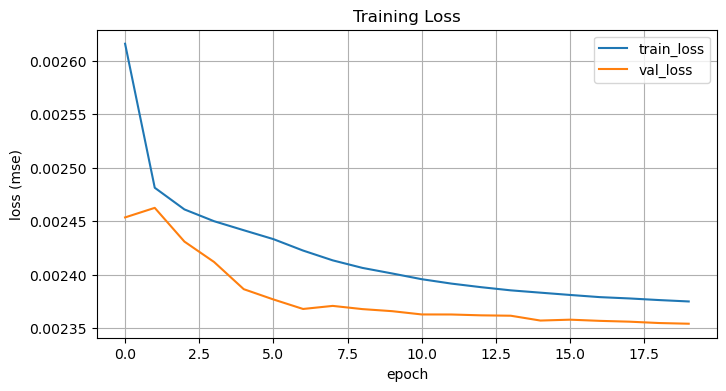

In [ ]:
"""
Train LSTM on vitals timeseries. This script:
 - loads or requires a timeseries CSV at data/vitals/human_vital_signs_timeseries.csv
 - builds sequences (seq_length adjustable)
 - trains an LSTM (early stopping & checkpoint)
 - saves model and scaler to models/timeseries/
"""
import os
import numpy as np
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split

import sys
sys.path.append(os.path.abspath("src"))  # Ensure src/ is in the import path
from timeseries.preprocess_vitals import load_timeseries, make_sequences

MODEL_DIR = os.path.join("models", "timeseries")
os.makedirs(MODEL_DIR, exist_ok=True)

SEQ_LENGTH = 10
BATCH_SIZE = 32
EPOCHS = 20
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(input_shape[-1], name="output_vitals")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def main():
    print("Loading timeseries (or error if none)...")
    df_ts = load_timeseries()
    X, y, scaler, vitals = make_sequences(df_ts, seq_length=SEQ_LENGTH)

    if X.size == 0:
        print("No sequences created. Exiting.")
        return

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    print(f"Train samples: {X_train.shape[0]}, Val samples: {X_val.shape[0]}")

    model = build_model(input_shape=(SEQ_LENGTH, X.shape[2]))
    ckpt_path = os.path.join(MODEL_DIR, "best_lstm_vitals.keras")
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss")
    ]

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)

    # Save final model and artifacts
    final_model_path = os.path.join(MODEL_DIR, "lstm_vitals.h5")
    model.save(final_model_path)
    print(f"Saved final model: {final_model_path}")

    # Save scaler and a few samples for later inference / debugging
    joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))
    np.save(os.path.join(MODEL_DIR, "X_train_sample.npy"), X_train[:min(200, len(X_train))])
    np.save(os.path.join(MODEL_DIR, "y_train_sample.npy"), y_train[:min(200, len(y_train))])
    print(f"Saved scaler and sample arrays to {MODEL_DIR}")

    # Save training history plot
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss (mse)")
        plt.title("Training Loss")
        plt.grid(True)
        plt.savefig(os.path.join(MODEL_DIR, "training_loss.png"))
        print("Saved training_loss.png")
    except Exception as e:
        print("Could not save training plot (matplotlib missing?). Error:", e)

if __name__ == "__main__":
    main()


In [ ]:
"""
Evaluate saved LSTM on full dataset sequences (prints MAE, RMSE, R2).
Saves predictions CSV: models/timeseries/predictions.csv
"""
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.timeseries.preprocess_vitals import load_timeseries, make_sequences

MODEL_DIR = os.path.join("models", "timeseries")
MODEL_PATH = os.path.join(MODEL_DIR, "lstm_vitals.h5")

def main():
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model not found: {MODEL_PATH}. Run train_lstm_vitals.py first.")
    df_ts = load_timeseries()
    X, y, scaler, vitals = make_sequences(df_ts, seq_length=10)

    if X.size == 0:
        print("No sequences to evaluate.")
        return

    import tensorflow as tf
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    preds = model.predict(X)

    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    try:
        r2 = r2_score(y, preds)
    except Exception:
        r2 = float("nan")

    print(f"Evaluation -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # Save a CSV with a few predictions (inverse-scaling not applied because saved scaler is in models folder)
    out_df = pd.DataFrame(np.hstack([y[:200], preds[:200]]),
                          columns=[f"true_{c}" for c in vitals] + [f"pred_{c}" for c in vitals])
    out_path = os.path.join(MODEL_DIR, "predictions_preview.csv")
    out_df.to_csv(out_path, index=False)
    print(f"Saved predictions preview to {out_path}")

if __name__ == "__main__":
    main()



Dropped 0 rows with missing vitals. Rows remaining: 4000400
Created sequences: X.shape=(2000200, 10, 6), y.shape=(2000200, 6), patients_with_sequences=200020
62507/62507 ━━━━━━━━━━━━━━━━━━━━ 264s 4ms/step
Evaluation -> MAE: 0.0384, RMSE: 0.0485, R2: 0.9280
Saved predictions preview to models\timeseries\predictions_preview.csv


In [ ]:
"""
Quick inference demo: load last SEQ_LENGTH readings for a patient and predict next vitals.
Usage: edit PATIENT_ID variable or make into CLI.
"""
import os
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
from src.timeseries.preprocess_vitals import load_timeseries

MODEL_DIR = os.path.join("models", "timeseries")
MODEL_PATH = os.path.join(MODEL_DIR, "lstm_vitals.h5")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.joblib")
SEQ_LENGTH = 10

def predict_for_patient(patient_id):
    if not os.path.exists(MODEL_PATH) or not os.path.exists(SCALER_PATH):
        raise FileNotFoundError("Train the model first (train_lstm_vitals.py)")

    df = load_timeseries()
    df = df.sort_values(["patient_id", "time"])
    df = df[df["patient_id"] == patient_id]
    if len(df) < SEQ_LENGTH:
        raise ValueError(f"Not enough rows ({len(df)}) for patient {patient_id}; need >= {SEQ_LENGTH}")

    vitals_cols = ["heart_rate", "respiratory_rate", "temperature", "spo2", "systolic_bp", "diastolic_bp"]
    recent = df[vitals_cols].tail(SEQ_LENGTH).values.astype(float)
    scaler = joblib.load(SCALER_PATH)

    # Scale recent vitals
    recent_scaled = scaler.transform(recent)
    X = np.expand_dims(recent_scaled, axis=0)  # shape: (1, seq, feats)

    # ✅ Load model safely without metrics
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

    # Predict next step
    pred_scaled = model.predict(X, verbose=0)[0]

    # Inverse transform back to original scale
    pred_original = scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]

    return dict(zip(vitals_cols, pred_original))


if __name__ == "__main__":
    # change this patient id as needed
    patient_id = 1
    print("Predicting next vitals for patient:", patient_id)
    try:
        pred = predict_for_patient(patient_id)
        print("Predicted next vitals (original scale):")
        for k, v in pred.items():
            print(f"  {k}: {v:.2f}")
    except Exception as e:
        print("Error:", e)


Predicting next vitals for patient: 1


c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Predicted next vitals (original scale):
  heart_rate: 61.02
  respiratory_rate: 11.98
  temperature: 36.82
  spo2: 95.71
  systolic_bp: 124.17
  diastolic_bp: 86.70


Segment 7: Pretrained Models (BioBERT / ClinicalBERT)

In [ ]:
!pip install transformers torch tqdm scikit-learn pandas
import os
import torch


     ---------------------------------------- 0.0/41.4 kB ? eta -:--:--
     -------------------------------------- 41.4/41.4 kB 663.7 kB/s eta 0:00:00
  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.0 MB 5.5 MB/s eta 0:00:03
   --- ------------------------------------ 1.2/12.0 MB 15.1 MB/s eta 0:00:01
   ------ --------------------------------- 1.9/12.0 MB 17.0 MB/s eta 0:00:01
   ---------- ----------------------------- 3.1/12.0 MB 17.8 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.0 MB 19.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.4/12.0 MB 20.2 MB/s eta 0:00:01
   ---------------- ---------

In [ ]:
"""
Preprocess clinical notes for BioBERT / ClinicalBERT analysis.
Extract text from NOTEEVENTS.csv, clean it, and sample manageable size for embeddings.
"""
import os
import pandas as pd
import re

DATA_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/testing data", "NOTEEVENTS_sorted.csv")
OUT_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/pretrained_models", "cleaned_notes.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s.,]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def preprocess_notes(sample_size=1000):
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"NOTEEVENTS.csv not found at {DATA_FILE}")

    print("🔹 Loading notes...")
    df = pd.read_csv(DATA_FILE, usecols=["ROW_ID", "CATEGORY", "TEXT"], low_memory=False)

    print(f"✅ Loaded {len(df)} notes. Sampling {sample_size} for embedding generation...")
    df = df.sample(n=min(sample_size, len(df)), random_state=42)
    df["clean_text"] = df["TEXT"].apply(clean_text)

    os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
    df.to_csv(OUT_FILE, index=False)
    print(f"✅ Saved cleaned sample to {OUT_FILE}")
    return OUT_FILE

if __name__ == "__main__":
    preprocess_notes()


🔹 Loading notes...
✅ Loaded 482770 notes. Sampling 1000 for embedding generation...
✅ Saved cleaned sample to C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models\cleaned_notes.csv


In [ ]:
!pip install huggingface_hub[hf_xet]

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB 682.7 kB/s eta 0:00:05
    --------------------------------------- 0.0/2.8 MB 653.6 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.8 MB 901.1 kB/s eta 0:00:03
   --------- ------------------------------ 0.6/2.8 MB 4.5 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.5 MB/s eta 0:00:00


In [ ]:
"""
Use pretrained BioBERT / ClinicalBERT to embed and classify clinical notes.
Outputs embeddings and example classification.
"""
import os
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
os.environ["OMP_NUM_THREADS"] = "4"

MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
DATA_FILE = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/pretrained_models", "cleaned_notes.csv")
OUT_DIR = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/pretrained_models")
os.makedirs(OUT_DIR, exist_ok=True)

def load_model():
    print(f"🔹 Loading model: {MODEL_NAME}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    return tokenizer, model

def compute_embeddings(texts, tokenizer, model, batch_size=8):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
            batch = texts[i:i+batch_size]
            tokens = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt")
            outputs = model(**tokens)
            # mean pooling over tokens
            emb = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(emb.cpu())
    return torch.cat(embeddings)

def main():
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Cleaned notes not found. Run preprocess_text.py first.")

    df = pd.read_csv(DATA_FILE)
    texts = df["clean_text"].tolist()

    tokenizer, model = load_model()
    print("🔹 Computing embeddings for clinical notes...")
    note_embeddings = compute_embeddings(texts, tokenizer, model)
    print(f"✅ Embeddings shape: {note_embeddings.shape}")

    emb_file = os.path.join(OUT_DIR, "note_embeddings.pt")
    torch.save(note_embeddings, emb_file)
    print(f"✅ Saved embeddings to {emb_file}")

    # Example: clustering or classification
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(note_embeddings)
    df["cluster"] = kmeans.labels_
    df.to_csv(os.path.join(OUT_DIR, "clustered_notes.csv"), index=False)
    print(f"✅ Saved clustered notes with labels → {OUT_DIR}/clustered_notes.csv")

if __name__ == "__main__":
    main()


🔹 Loading model: emilyalsentzer/Bio_ClinicalBERT
🔹 Computing embeddings for clinical notes...


Embedding batches: 100%|██████████| 125/125 [02:17<00:00,  1.10s/it]

✅ Embeddings shape: torch.Size([1000, 768])
✅ Saved embeddings to C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models\note_embeddings.pt
✅ Saved clustered notes with labels → C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models/clustered_notes.csv



c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


🔹 Loading embeddings and cluster assignments...
🔹 Computing PCA...
✅ Saved PCA plot → C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models\plots/embeddings_pca.png
🔹 Computing t-SNE (this may take ~2–5 min)...
✅ Saved t-SNE plot → C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models\plots/embeddings_tsne.png


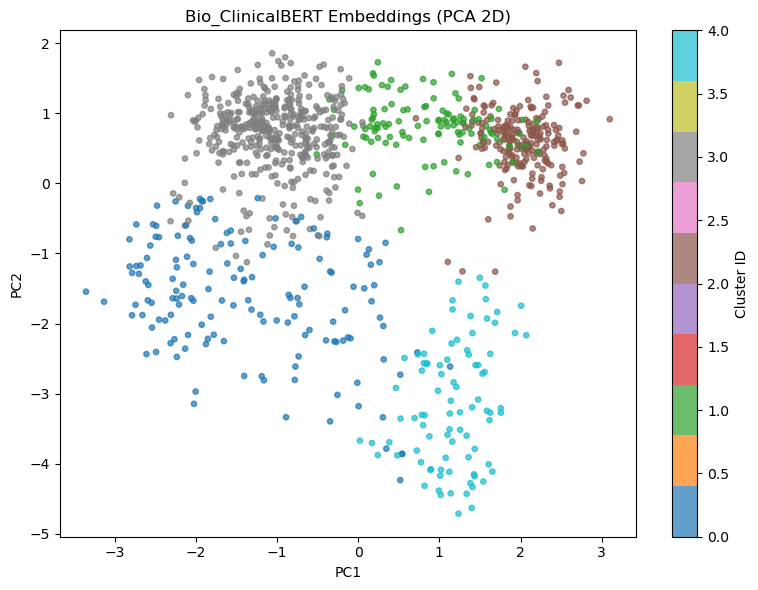

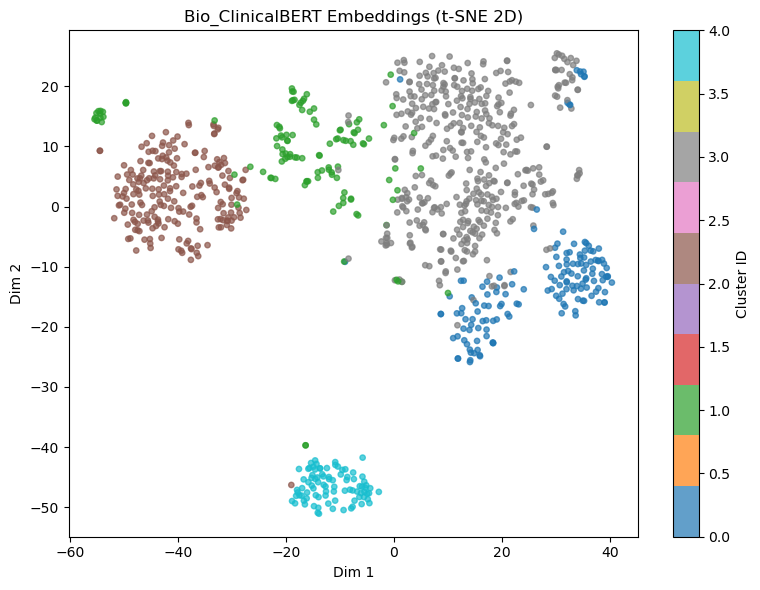

In [ ]:
"""
Visualize Bio_ClinicalBERT embeddings of clinical notes using PCA and t-SNE.
Generates 2D scatter plots colored by cluster.
"""
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

MODEL_DIR = os.path.join("C:/Users/Bernietta/OneDrive", "guvi/guvi_project/main_project/src/pretrained_models")
EMB_FILE = os.path.join(MODEL_DIR, "note_embeddings.pt")
CLUSTER_FILE = os.path.join(MODEL_DIR, "clustered_notes.csv")
OUT_DIR = os.path.join(MODEL_DIR, "plots")

os.makedirs(OUT_DIR, exist_ok=True)

def main():
    if not os.path.exists(EMB_FILE) or not os.path.exists(CLUSTER_FILE):
        raise FileNotFoundError("Missing embeddings or clustered notes. Run analyze_clinical_notes.py first.")

    print("🔹 Loading embeddings and cluster assignments...")
    embeddings = torch.load(EMB_FILE).numpy()
    df = pd.read_csv(CLUSTER_FILE)

    if "cluster" not in df.columns:
        raise ValueError("Cluster column missing in clustered_notes.csv")

    # --- PCA ---
    print("🔹 Computing PCA...")
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(pca_result[:,0], pca_result[:,1], c=df["cluster"], cmap="tab10", s=15, alpha=0.7)
    plt.colorbar(label="Cluster ID")
    plt.title("Bio_ClinicalBERT Embeddings (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "embeddings_pca.png"))
    print(f"✅ Saved PCA plot → {OUT_DIR}/embeddings_pca.png")

    # --- t-SNE ---
    print("🔹 Computing t-SNE (this may take ~2–5 min)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    tsne_result = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(tsne_result[:,0], tsne_result[:,1], c=df["cluster"], cmap="tab10", s=15, alpha=0.7)
    plt.colorbar(label="Cluster ID")
    plt.title("Bio_ClinicalBERT Embeddings (t-SNE 2D)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "embeddings_tsne.png"))
    print(f"✅ Saved t-SNE plot → {OUT_DIR}/embeddings_tsne.png")

if __name__ == "__main__":
    main()


In [ ]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 744.7 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.7 MB 744.7 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.7 MB 888.4 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 888.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 1.1 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 1.1 MB/s eta 0:00:02
   ------------ --------------------------- 0.5/1.7 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers
import os   

In [ ]:
!pip install transformers torch scikit-learn tqdm pandas matplotlib


In [ ]:
"""
prepare_multimodal.py
- Loads note embeddings and clustered notes
- Maps notes to SUBJECT_ID (using NOTEEVENTS if needed)
- Aggregates embeddings per SUBJECT_ID (mean pooling)
- Loads vitals data (with 'Risk Category'), computes per-patient features
- Merges into final multimodal dataset with risk label
"""

import os
import pandas as pd
import numpy as np
import torch

# -------------------- PATHS --------------------
EMB_FILE = os.path.join("models", "pretrained", "note_embeddings.pt")
CLUSTERED_NOTES = os.path.join(
    "C:/Users/Bernietta/OneDrive",
    "guvi/guvi_project/main_project/src/pretrained_models",
    "cleaned_notes.csv"
)
NOTEEVENTS = os.path.join(
    "C:/Users/Bernietta/OneDrive",
    "guvi/guvi_project/main_project/testing data",
    "NOTEEVENTS_sorted.csv"
)
VITALS_FILE = os.path.join(
    "C:/Users/Bernietta/OneDrive",
    "guvi/guvi_project/main_project/human_vital_signs_dataset_2024.csv",
    "human_vital_signs_dataset_2024.csv"
)
OUT_DIR = os.path.join(
    "C:/Users/Bernietta/OneDrive",
    "guvi/guvi_project/main_project/src/pretrained_models",
    "pretrained"
)
OUT_FILE = os.path.join(OUT_DIR, "multimodal_dataset.csv")

# -------------------------------------------------

def load_embeddings():
    if not os.path.exists(EMB_FILE):
        raise FileNotFoundError(f"Embeddings not found: {EMB_FILE}")
    emb = torch.load(EMB_FILE)
    emb = emb.numpy() if hasattr(emb, "numpy") else np.array(emb)
    print(f"✅ Loaded embeddings: shape={emb.shape}")
    return emb


def load_clustered_notes():
    if not os.path.exists(CLUSTERED_NOTES):
        raise FileNotFoundError(f"Clustered notes not found at {CLUSTERED_NOTES}")
    df = pd.read_csv(CLUSTERED_NOTES, low_memory=False)
    print(f"✅ Loaded clustered notes: {len(df)} rows")
    return df


def map_notes_to_subjects(df_notes):
    """Map notes to SUBJECT_ID using NOTEEVENTS if necessary"""
    df = df_notes.copy()
    if "SUBJECT_ID" in df.columns:
        print("Using SUBJECT_ID column from notes CSV.")
        return df.rename(columns={"SUBJECT_ID": "subject_id"})

    if "ROW_ID" in df.columns:
        print("Notes CSV has ROW_ID — mapping to SUBJECT_ID using NOTEEVENTS.csv...")
        notes_map = pd.read_csv(NOTEEVENTS, usecols=["ROW_ID", "SUBJECT_ID"], low_memory=False)
        merged = df.merge(notes_map, on="ROW_ID", how="left")
        merged = merged.rename(columns={"SUBJECT_ID": "subject_id"})
        print(f"✅ Mapped to {merged['subject_id'].nunique()} unique patients.")
        return merged

    raise ValueError("❌ No SUBJECT_ID or ROW_ID column found in clustered notes.")


def aggregate_embeddings_per_subject(df_notes, embeddings):
    """Aggregate embeddings by patient"""
    if len(df_notes) != embeddings.shape[0]:
        print("⚠️ Warning: Embedding count doesn't match notes rows; aligning by index.")
    df_notes = df_notes.reset_index(drop=True)
    emb_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
    merged = pd.concat([df_notes.reset_index(drop=True), emb_df], axis=1)
    merged = merged.dropna(subset=["subject_id"])
    merged["subject_id"] = merged["subject_id"].astype(int)
    # Only aggregate embedding columns
    emb_cols = [f"emb_{i}" for i in range(embeddings.shape[1])]
    agg = merged.groupby("subject_id")[emb_cols].mean().reset_index()
    print(f"✅ Aggregated embeddings: {agg.shape[0]} patients.")
    return agg

def build_vitals_features():
    """Compute per-patient aggregated vitals with 'Risk Category' label"""
    if not os.path.exists(VITALS_FILE):
        raise FileNotFoundError(f"Vitals file not found: {VITALS_FILE}")
    df = pd.read_csv(VITALS_FILE, low_memory=False)

    # Standardize column names
    df = df.rename(columns={
        "Patient ID": "patient_id",
        "Heart Rate": "heart_rate",
        "Respiratory Rate": "respiratory_rate",
        "Body Temperature": "temperature",
        "Oxygen Saturation": "spo2",
        "Systolic Blood Pressure": "systolic_bp",
        "Diastolic Blood Pressure": "diastolic_bp",
        "Risk Category": "risk_category"
    })

    # Convert vitals to numeric
    vitals_cols = ["heart_rate", "respiratory_rate", "temperature", "spo2", "systolic_bp", "diastolic_bp"]
    for col in vitals_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Aggregate stats per patient
    agg = df.groupby("patient_id")[vitals_cols].agg(["mean", "std", "min", "max"])
    agg.columns = ["_".join(col).strip() for col in agg.columns.values]
    agg = agg.reset_index()

    # Risk label (convert to 0/1)
    df["risk_category"] = df["risk_category"].astype(str).str.strip().str.lower()
    risk_map = {"low risk": 0, "medium risk": 1, "high risk": 2}
    df["risk"] = df["risk_category"].map(risk_map)

    # Attach most frequent risk label per patient
    risk_df = df.groupby("patient_id")["risk"].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan).reset_index()
    agg = agg.merge(risk_df, on="patient_id", how="left")

    print(f"✅ Built vitals features for {len(agg)} patients. Label found: True")
    return agg


def main():
    emb = load_embeddings()
    notes = load_clustered_notes()
    notes_mapped = map_notes_to_subjects(notes)
    emb_per_patient = aggregate_embeddings_per_subject(notes_mapped, emb)
    vitals_feats = build_vitals_features()

    merged = emb_per_patient.merge(vitals_feats, left_on="subject_id", right_on="patient_id", how="inner")

    if merged.empty:
        print("❌ No merged rows found! Check ID consistency between notes and vitals.")
        return

    os.makedirs(OUT_DIR, exist_ok=True)
    merged.to_csv(OUT_FILE, index=False)
    print(f"✅ Saved multimodal dataset to {OUT_FILE} (rows: {len(merged)})")


if __name__ == "__main__":
    main()


✅ Loaded embeddings: shape=(1000, 768)
✅ Loaded clustered notes: 1000 rows
Notes CSV has ROW_ID — mapping to SUBJECT_ID using NOTEEVENTS.csv...
✅ Mapped to 861 unique patients.
✅ Aggregated embeddings: 861 patients.
✅ Built vitals features for 200020 patients. Label found: True
✅ Saved multimodal dataset to C:/Users/Bernietta/OneDrive\guvi/guvi_project/main_project/src/pretrained_models\pretrained\multimodal_dataset.csv (rows: 861)


In [ ]:
"""
Train multimodal classifier on concatenated text embeddings + vitals features.
Saves: RandomForest baseline and a Keras NN (saved in models/pretrained/)
"""
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import joblib
import tensorflow as tf

DATA_FILE = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/pretrained_models/pretrained/multimodal_dataset.csv")
OUT_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/pretrained_models/pretrained")
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_SEED = 42

def load_dataset(path=DATA_FILE):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Multimodal dataset not found at {path}. Run prepare_multimodal.py first.")
    df = pd.read_csv(path, low_memory=False)
    print(f"Loaded multimodal dataset: {len(df)} rows, columns: {df.columns.tolist()}")
    return df

def split_features_labels(df):
    # find embedding columns emb_0..emb_n
    emb_cols = [c for c in df.columns if c.startswith("emb_")]
    # find vitals aggregate columns (others)
    other_cols = [c for c in df.columns if c not in emb_cols + ["subject_id","patient_id","risk_label_raw","risk"]]
    # pick numeric other cols
    numeric_other = [c for c in other_cols if df[c].dtype.kind in "fi"]
    X_emb = df[emb_cols].values
    X_tab = df[numeric_other].fillna(0).values
    X = np.hstack([X_emb, X_tab])
    if "risk" in df.columns:
        y = df["risk"].astype(int).values
    else:
        raise ValueError("No 'risk' label present in multimodal dataset.")
    print(f"Feature sizes -> emb:{X_emb.shape}, tab:{X_tab.shape}, combined:{X.shape}")
    return X, y, emb_cols + numeric_other

def train_rf(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    probs = rf.predict_proba(X_val)[:,1] if hasattr(rf, "predict_proba") else None
    print("RandomForest Results:")
    print(classification_report(y_val, preds))
    if probs is not None:
        print("ROC AUC:", roc_auc_score(y_val, probs))
    return rf

def build_keras_nn(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model

def main():
    df = load_dataset()
    X, y, feature_names = split_features_labels(df)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # RandomForest baseline
    rf = train_rf(X_train, y_train, X_val, y_val)
    joblib.dump(rf, os.path.join(OUT_DIR, "multimodal_rf.joblib"))

    # Keras NN
    nn = build_keras_nn(X_train.shape[1])
    early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early], verbose=1)
    nn.save(os.path.join(OUT_DIR, "multimodal_nn.h5"))
    joblib.dump(scaler, os.path.join(OUT_DIR, "multimodal_scaler.joblib"))
    print("✅ Saved RandomForest, NN model and scaler in", OUT_DIR)

    # Evaluate NN
    preds = (nn.predict(X_val).ravel() >= 0.5).astype(int)
    probs = nn.predict(X_val).ravel()
    print("Neural Net Results:")
    print(classification_report(y_val, preds))
    print("ROC AUC:", roc_auc_score(y_val, probs))

if __name__ == "__main__":
    main()


Loaded multimodal dataset: 861 rows, columns: ['subject_id', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82', 'emb_83', 'emb_84', 'emb_85', 'emb_86', 'emb_87', 'emb_88', 'emb_89', 'emb_90', 'emb_91', 'emb_92', 'emb_93', 'emb_94',

✅ Saved RandomForest, NN model and scaler in C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/pretrained_models/pretrained
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Neural Net Results:
              precision    recall  f1-score   support

           0       0.40      0.05      0.08        44
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        43

    accuracy                           0.02        87
   macro avg       0.13      0.02      0.03        87
weighted avg       0.20      0.02      0.04        87

ROC AUC: 0.48784355179704014


c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Bernietta\anaco

In [ ]:
"""
Quick demo: load a patient's vitals and note-embedding to predict risk.
"""
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf

OUT_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/pretrained_models/pretrained")
MODEL_RF = os.path.join(OUT_DIR, "multimodal_rf.joblib")
MODEL_NN = os.path.join(OUT_DIR, "multimodal_nn.h5")
SCALER = os.path.join(OUT_DIR, "multimodal_scaler.joblib")
DATA = os.path.join(OUT_DIR, "multimodal_dataset.csv")

def infer_for_patient(patient_id):
    if not os.path.exists(DATA):
        raise FileNotFoundError("Run prepare_multimodal.py first.")
    df = pd.read_csv(DATA)
    # find row
    if "subject_id" in df.columns:
        row = df[df["subject_id"]==patient_id]
    else:
        row = df[df["patient_id"]==patient_id]
    if row.empty:
        raise ValueError("Patient not found in multimodal dataset.")
    # prepare features
    emb_cols = [c for c in df.columns if c.startswith("emb_")]
    other_cols = [c for c in df.columns if c not in emb_cols + ["subject_id","patient_id","risk_label_raw","risk"]]
    feat_cols = emb_cols + [c for c in other_cols if row[c].dtype.kind in "fi" or np.issubdtype(type(row[c].values[0]), np.number)]
    X = row[feat_cols].values.astype(float)
    scaler = joblib.load(SCALER)
    Xs = scaler.transform(X)
    # RF
    rf = joblib.load(MODEL_RF)
    prob_rf = rf.predict_proba(Xs)[:,1]
    # NN
    nn = tf.keras.models.load_model(MODEL_NN)
    prob_nn = nn.predict(Xs).ravel()
    return {"rf_prob": float(prob_rf[0]), "nn_prob": float(prob_nn[0])}

if __name__ == "__main__":
    pid = int(input("Enter patient id to infer: "))
    print(infer_for_patient(pid))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
{'rf_prob': 0.9, 'nn_prob': 0.9857540726661682}


🏥 Segment 8: Healthcare Chatbot (RAG-based)

In [ ]:
!pip install sentence-transformers faiss-cpu numpy pandas torch


   ---------------------------------------- 0.0/486.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/486.6 kB ? eta -:--:--
   --- ------------------------------------ 41.0/486.6 kB ? eta -:--:--
   --- ------------------------------------ 41.0/486.6 kB ? eta -:--:--
   ----- --------------------------------- 71.7/486.6 kB 558.5 kB/s eta 0:00:01
   --------- ---------------------------- 122.9/486.6 kB 717.5 kB/s eta 0:00:01
   ------------- ------------------------ 174.1/486.6 kB 871.5 kB/s eta 0:00:01
   ---------------------- ----------------- 276.5/486.6 kB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 286.7/486.6 kB 1.1 MB/s eta 0:00:01
   -------------------------- ----------- 337.9/486.6 kB 999.0 kB/s eta 0:00:01
   ------------------------------ --------- 368.6/486.6 kB 1.0 MB/s eta 0:00:01
   ----------------------------- -------- 378.9/486.6 kB 905.7 kB/s eta 0:00:01
   -------------------------------- ----- 419.8/486.6 kB 904.2 kB/s eta 0:

In [ ]:
!pip install huggingface_hub[hf_xet]

In [ ]:
import os
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

DATA_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/faq_corpus.csv"
OUT_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
os.makedirs(OUT_DIR, exist_ok=True)

def main():
    df = pd.read_csv(DATA_FILE)
    model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, works offline

    print("🔹 Encoding FAQ questions...")
    embeddings = model.encode(df['Question'].tolist(), convert_to_numpy=True, show_progress_bar=True)

    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    faiss.write_index(index, os.path.join(OUT_DIR, "faq_index.faiss"))

    np.save(os.path.join(OUT_DIR, "faq_questions.npy"), df['Question'].values)
    df.to_csv(os.path.join(OUT_DIR, "faq_with_answers.csv"), index=False)

    print(f"✅ Saved FAISS index and FAQ data to {OUT_DIR}")

if __name__ == "__main__":
    main()


🔹 Encoding FAQ questions...


Batches:   0%|          | 0/512 [00:00<?, ?it/s]

✅ Saved FAISS index and FAQ data to C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot


In [ ]:
import os
import faiss
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

# Paths
MODEL_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
INDEX_FILE = os.path.join(MODEL_DIR, "faq_index.faiss")
FAQ_FILE = os.path.join(MODEL_DIR, "faq_with_answers.csv")
QUESTIONS_NPY = os.path.join(MODEL_DIR, "faq_questions.npy")

# Load vector index + LLM
retriever = SentenceTransformer('all-MiniLM-L6-v2')
index = faiss.read_index(INDEX_FILE)
faq_df = pd.read_csv(FAQ_FILE)
faq_questions = np.load(QUESTIONS_NPY, allow_pickle=True)

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

def retrieve_context(query, k=3):
    q_emb = retriever.encode([query])
    D, I = index.search(q_emb, k)
    contexts = [faq_df.iloc[i]["Answer"] for i in I[0]]
    return "\n".join(contexts)

def generate_response(query):
    context = retrieve_context(query)
    input_text = f"Context:\n{context}\n\nUser: {query}\nAI:"
    inputs = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=150, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(outputs[:, inputs.shape[-1]:][0], skip_special_tokens=True)

if __name__ == "__main__":
    print("🤖 Healthcare Chatbot ready! Type 'exit' to quit.")
    while True:
        user_query = input("\nYou: ")
        if user_query.lower() in ["exit", "quit"]:
            break
        answer = generate_response(user_query)
        print("Bot:", answer)


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

c:\Users\Bernietta\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Bernietta\.cache\huggingface\hub\models--microsoft--DialoGPT-medium. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

🤖 Healthcare Chatbot ready! Type 'exit' to quit.


In [ ]:
import pandas as pd
import os

folder = "testing data/patient_satisfaction"
files = [
    "cms_hospital_patient_satisfaction_2019.csv",
    "cms_hospital_patient_satisfaction_2020.csv"
]

dfs = [pd.read_csv(os.path.join(folder, f), low_memory=False) for f in files]
merged_df = pd.concat(dfs, ignore_index=True)

print("✅ Merged shape:", merged_df.shape)
print("✅ Columns:", merged_df.columns.tolist())

merged_df.to_csv(os.path.join(folder, "merged_patient_satisfaction.csv"), index=False)
print("✅ Saved merged file → merged_patient_satisfaction.csv")


✅ Merged shape: (884988, 43)
✅ Columns: ['Facility ID', 'Facility Name', 'Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number', 'HCAHPS Measure ID', 'HCAHPS Question', 'HCAHPS Answer Description', 'Patient Survey Star Rating', 'Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent', 'HCAHPS Answer Percent Footnote', 'HCAHPS Linear Mean Value', 'Number of Completed Surveys', 'Number of Completed Surveys Footnote', 'Survey Response Rate Percent', 'Survey Response Rate Percent Footnote', 'Start Date', 'End Date', 'Year', 'Hospital Type', 'Hospital Ownership', 'Emergency Services', 'Meets criteria for promoting interoperability of EHRs', 'Hospital overall rating', 'Hospital overall rating footnote', 'Mortality national comparison', 'Mortality national comparison footnote', 'Safety of care national comparison', 'Safety of care national comparison footnote', 'Readmission national comparison', 'Readmission national comparison footnote', 'Patient experience national comp

In [ ]:
import pandas as pd

df = pd.read_csv("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/merged_patient_satisfaction.csv", nrows=10)
print("✅ Loaded sample successfully.")
print("Columns:", df.columns.tolist())
print("\nSample rows:")
print(df.head())


✅ Loaded sample successfully.
Columns: ['Facility ID', 'Facility Name', 'Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number', 'HCAHPS Measure ID', 'HCAHPS Question', 'HCAHPS Answer Description', 'Patient Survey Star Rating', 'Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent', 'HCAHPS Answer Percent Footnote', 'HCAHPS Linear Mean Value', 'Number of Completed Surveys', 'Number of Completed Surveys Footnote', 'Survey Response Rate Percent', 'Survey Response Rate Percent Footnote', 'Start Date', 'End Date', 'Year', 'Hospital Type', 'Hospital Ownership', 'Emergency Services', 'Meets criteria for promoting interoperability of EHRs', 'Hospital overall rating', 'Hospital overall rating footnote', 'Mortality national comparison', 'Mortality national comparison footnote', 'Safety of care national comparison', 'Safety of care national comparison footnote', 'Readmission national comparison', 'Readmission national comparison footnote', 'Patient experience national compa

In [ ]:
"""
preprocess_satisfaction.py
- Loads merged HCAHPS CSV
- Creates a sentiment label from 'HCAHPS Answer Description' and 'Patient Survey Star Rating'
- Produces a small text column 'text_input' (HCAHPS Question + Answer Description)
- Saves prepared CSV for modeling: models/chatbot/satisfaction_for_model.csv
"""
import os
import pandas as pd
import numpy as np

IN_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/merged_patient_satisfaction.csv"  # adjust path if needed
OUT_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
OUT_FILE = os.path.join(OUT_DIR, "satisfaction_for_model.csv")
os.makedirs(OUT_DIR, exist_ok=True)

# mapping rules
POSITIVE_ANSWERS = {"always", "yes", "excellent", "very good", "4", "5"}
NEGATIVE_ANSWERS = {"never", "no", "poor", "fair", "sometimes", "1", "2"}
# We'll treat 'usually' and '3' as neutral by default
NEUTRAL_ANSWERS = {"usually", "sometimes", "3", "neutral"}

def map_answer_to_sentiment(ans_desc, star):
    # Normalize
    if pd.isna(ans_desc):
        ans_desc = ""
    a = str(ans_desc).strip().lower()
    # try answer text first
    if any(tok in a for tok in POSITIVE_ANSWERS):
        return 2  # 2 = positive
    if any(tok in a for tok in NEGATIVE_ANSWERS):
        return 0  # 0 = negative
    if any(tok in a for tok in NEUTRAL_ANSWERS):
        return 1  # 1 = neutral
    # fallback to star rating if present
    try:
        s = float(star)
        if s >= 4.0:
            return 2
        elif s >= 3.0:
            return 1
        else:
            return 0
    except Exception:
        return 1  # neutral default

def main():
    print("Loading merged HCAHPS dataset...")
    df = pd.read_csv(IN_FILE, low_memory=False)
    # create text_input
    df["HCAHPS Question"] = df["HCAHPS Question"].astype(str)
    df["HCAHPS Answer Description"] = df["HCAHPS Answer Description"].astype(str)
    df["text_input"] = df["HCAHPS Question"].str.strip() + " -- " + df["HCAHPS Answer Description"].str.strip()

    # create label
    df["sentiment"] = df.apply(lambda r: map_answer_to_sentiment(r["HCAHPS Answer Description"], r.get("Patient Survey Star Rating", np.nan)), axis=1)

    # keep columns useful for modeling and context
    keep = ["Facility ID","Facility Name","City","State","Year","text_input","HCAHPS Answer Percent","Patient Survey Star Rating","sentiment","HCAHPS Measure ID","HCAHPS Question","HCAHPS Answer Description"]
    keep_existing = [c for c in keep if c in df.columns]
    df_out = df[keep_existing].copy()

    df_out.to_csv(OUT_FILE, index=False)
    print(f"Saved preprocessed data to {OUT_FILE} (rows: {len(df_out)})")

if __name__ == "__main__":
    main()


Loading merged HCAHPS dataset...
Saved preprocessed data to C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot\satisfaction_for_model.csv (rows: 884988)


In [ ]:
"""
train_sentiment_model.py
- Trains TF-IDF + LogisticRegression to predict sentiment (0=neg,1=neu,2=pos)
- Saves model, vectorizer, label encoder to models/chatbot/
"""
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

IN_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/satisfaction_for_model.csv"
OUT_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
os.makedirs(OUT_DIR, exist_ok=True)

def main():
    print("Loading preprocessed data...")
    df = pd.read_csv(IN_FILE, low_memory=False)
    # drop rows with NaN text or sentiment
    df = df.dropna(subset=["text_input","sentiment"])
    X = df["text_input"].astype(str).values
    y = df["sentiment"].astype(int).values

    # simple split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Building TF-IDF vectorizer...")
    tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)
    X_train_t = tfidf.fit_transform(X_train)
    X_val_t = tfidf.transform(X_val)

    print("Training Logistic Regression...")
    clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
    clf.fit(X_train_t, y_train)

    print("Evaluating...")
    preds = clf.predict(X_val_t)
    print("Accuracy:", accuracy_score(y_val, preds))
    print(classification_report(y_val, preds, digits=4))

    # Save artifacts
    joblib.dump(tfidf, os.path.join(OUT_DIR, "tfidf_vectorizer.joblib"))
    joblib.dump(clf, os.path.join(OUT_DIR, "sentiment_clf.joblib"))
    print(f"Saved vectorizer and model to {OUT_DIR}")

if __name__ == "__main__":
    main()


Loading preprocessed data...
Building TF-IDF vectorizer...
Training Logistic Regression...
Evaluating...
Accuracy: 0.9386716234081741
              precision    recall  f1-score   support

           0     0.9673    0.9270    0.9467     43699
           1     0.9366    0.9549    0.9456     87755
           2     0.9166    0.9187    0.9176     45544

    accuracy                         0.9387    176998
   macro avg     0.9401    0.9335    0.9367    176998
weighted avg     0.9390    0.9387    0.9387    176998

Saved vectorizer and model to C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot


In [ ]:
"""
chatbot_empathy.py
- Simple console chatbot demo using the TF-IDF sentiment model + hospital context
"""
import os
import joblib
import pandas as pd
import numpy as np

MODEL_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
TFIDF_PATH = os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib")
CLF_PATH = os.path.join(MODEL_DIR, "sentiment_clf.joblib")
HOSPITAL_DATA = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/merged_patient_satisfaction.csv"  # used for facility-level context

def load_resources():
    tfidf = joblib.load(TFIDF_PATH)
    clf = joblib.load(CLF_PATH)
    df_hosp = pd.read_csv(HOSPITAL_DATA, low_memory=False)
    # Convert Patient Survey Star Rating to numeric for aggregation
    if "Patient Survey Star Rating" in df_hosp.columns:
        df_hosp["Patient Survey Star Rating"] = pd.to_numeric(df_hosp["Patient Survey Star Rating"], errors="coerce")
        summary = df_hosp.groupby("Facility ID")["Patient Survey Star Rating"].median().reset_index().rename(columns={"Patient Survey Star Rating":"median_star"})
    else:
        summary = pd.DataFrame()
    return tfidf, clf, summary

def sentiment_to_label(s):
    return {0:"negative", 1:"neutral", 2:"positive"}.get(int(s),"neutral")

def empathetic_reply(sentiment_label, user_text, facility_name=None, facility_star=None):
    if sentiment_label == "negative":
        base = "I'm really sorry you had a poor experience. That matters. "
        if facility_name and not np.isnan(facility_star) and facility_star < 3:
            base += f"I see that {facility_name} has a lower survey rating ({facility_star} stars). Would you like me to connect you with patient relations or provide a complaint form?"
        else:
            base += "Can you tell me more so I can help or escalate this to patient relations?"
    elif sentiment_label == "neutral":
        base = "Thanks for that feedback. I can help with information or forward this to the support team. What would you like to do?"
    else:  # positive
        base = "That's great to hear — thank you! If you'd like, you can leave a review or tell us what went well so we can pass it along."
    return base

def chat_loop():
    tfidf, clf, hosp_summary = load_resources()
    print("🤖 Empathy Chatbot (type 'exit' to quit)")
    while True:
        text = input("\nYou: ").strip()
        if text.lower() in ("exit","quit"):
            break
        X = tfidf.transform([text])
        pred = clf.predict(X)[0]
        label = sentiment_to_label(pred)
        # try to detect if user mentions a facility name (naive)
        facility_name = None; facility_star = None
        for _, row in hosp_summary.iterrows():
            # naive check: facility id or name in text (we only have facility_id summary here)
            pass
        reply = empathetic_reply(label, text, facility_name, facility_star)
        print("\nBot:", reply)

if __name__ == "__main__":
    chat_loop()


🤖 Empathy Chatbot (type 'exit' to quit)

Bot: Thanks for that feedback. I can help with information or forward this to the support team. What would you like to do?

Bot: That's great to hear — thank you! If you'd like, you can leave a review or tell us what went well so we can pass it along.

Bot: That's great to hear — thank you! If you'd like, you can leave a review or tell us what went well so we can pass it along.

Bot: That's great to hear — thank you! If you'd like, you can leave a review or tell us what went well so we can pass it along.

Bot: That's great to hear — thank you! If you'd like, you can leave a review or tell us what went well so we can pass it along.

Bot: Thanks for that feedback. I can help with information or forward this to the support team. What would you like to do?

Bot: Thanks for that feedback. I can help with information or forward this to the support team. What would you like to do?

Bot: Thanks for that feedback. I can help with information or forward t

Segment 9: Multilingual Translator

In [ ]:
!pip install langdetect

In [7]:


"""
translator.py
- Auto-detect language (langdetect)
- Translate text between English and regional languages using MarianMT (Helsinki-NLP)
- Caches tokenizers/models to avoid re-downloading
"""

import os
from typing import Tuple
from langdetect import detect, DetectorFactory
from transformers import MarianMTModel, MarianTokenizer
import torch

DetectorFactory.seed = 0  # deterministic langdetect

# Supported language codes (add more as needed)
# two-letter iso codes used by langdetect
SUPPORTED = {"hi","ta","te","ml","kn","bn","mr","gu","pa","ur","en"}

# cache dicts
_MODEL_CACHE = {}
_TOKENIZER_CACHE = {}

def detect_language(text: str) -> str:
    """Return language code using langdetect (e.g., 'en', 'hi')."""
    text = (text or "").strip()
    if text == "":
        return "en"
    try:
        lang = detect(text)
        return lang
    except Exception:
        return "en"

def get_marian_name(src: str, tgt: str) -> str:
    """Return best candidate model name for src->tgt.
    Try direct 'opus-mt-{src}-{tgt}'. If not supported, return None (caller will fallback via en).
    """
    model_name = f"Helsinki-NLP/opus-mt-{src}-{tgt}"
    return model_name

def load_model_and_tokenizer(model_name: str):
    """Load and cache Marian model + tokenizer for given model_name."""
    if model_name in _MODEL_CACHE:
        return _MODEL_CACHE[model_name], _TOKENIZER_CACHE[model_name]

    print(f"Loading model: {model_name} ... (this may take a moment)")
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    _MODEL_CACHE[model_name] = model
    _TOKENIZER_CACHE[model_name] = tokenizer
    return model, tokenizer

def translate_with_model(model_name: str, texts):
    """Translate list of texts using the specified Marian model."""
    model, tokenizer = load_model_and_tokenizer(model_name)
    # device placement
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # tokenize
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    translated = model.generate(**batch, num_beams=4, max_length=512)
    outs = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    return outs

def translate(text: str, target_lang: str = "en") -> Tuple[str,str]:
    """
    Translate text into target_lang.
    Returns (detected_source, translated_text)
    Workflow:
      - detect source lang
      - if source == target -> return text
      - try direct model src->tgt
      - else fallback: src->en (if src != 'en') then en->tgt (if tgt != 'en')
    """
    src = detect_language(text)
    src = src if src in SUPPORTED else src  # still use detected code; model availability checked later
    target = target_lang

    if src == target:
        return src, text

    # try direct model src->target
    direct_model = get_marian_name(src, target)
    try:
        if direct_model:
            # attempt to load; if not available, transformers will raise
            translated = translate_with_model(direct_model, [text])[0]
            return src, translated
    except Exception:
        # direct model not available or failed; we will fallback
        pass

    # fallback route: src -> en -> target
    try:
        if src != "en":
            model_se = get_marian_name(src, "en")
            translated_en = translate_with_model(model_se, [text])[0]
        else:
            translated_en = text

        if target != "en":
            model_et = get_marian_name("en", target)
            translated_final = translate_with_model(model_et, [translated_en])[0]
        else:
            translated_final = translated_en

        return src, translated_final
    except Exception as e:
        # if all fails return original text
        print("Translation fallback failed:", str(e))
        return src, text


In [ ]:
!pip install translator

In [ ]:
!pip install langdetect transformers torch

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install sacremoses

In [ ]:
 pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [8]:
"""
integrate_chatbot.py
- Shows how to call translator.translate() around existing chatbot pipeline
- Example: detect language -> translate user input to English -> run sentiment model -> translate reply back
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))

from health_translator.translator import translate, detect_language
import joblib
import os
import sentencepiece as spm

# paths for existing chatbot artifacts
TFIDF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/tfidf_vectorizer.joblib"
CLF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/sentiment_clf.joblib"

_tfidf, _clf = None, None
def load_chatbot_models():
    global _tfidf, _clf
    if _tfidf is None or _clf is None:
        if not os.path.exists(TFIDF_PATH) or not os.path.exists(CLF_PATH):
            raise FileNotFoundError("Chatbot models missing. Run training pipeline first.")
        _tfidf = joblib.load(TFIDF_PATH)
        _clf = joblib.load(CLF_PATH)
    return _tfidf, _clf

def sentiment_to_label(s):
    return {0:"negative", 1:"neutral", 2:"positive"}.get(int(s),"neutral")

def empathetic_reply(sentiment_label, facility_name=None, facility_star=None):
    if sentiment_label == "negative":
        base = "I'm really sorry you had a poor experience. That matters. Can I help escalate this to patient relations?"
    elif sentiment_label == "neutral":
        base = "Thanks for the feedback. How can I assist you further?"
    else:
        base = "That's great to hear — thank you! Would you like to share more details?"
    return base

def chat_once(user_text):
    # 1️⃣ Detect language and translate to English
    result = translate(user_text, target_lang="en")
    if isinstance(result, tuple):
        src_lang, text_en = result
    else:
        src_lang = detect_language(user_text)
        text_en = result

    print(f"[Detected: {src_lang}] Translated → EN: {text_en}")

    # 2️⃣ Run sentiment model
    tfidf, clf = load_chatbot_models()
    X = tfidf.transform([text_en])
    pred = clf.predict(X)[0]
    label = sentiment_to_label(pred)

    # 3️⃣ Generate empathetic reply in English
    reply_en = empathetic_reply(label)

    # 4️⃣ Translate reply back to user's language
    reply_local = reply_en if src_lang == "en" else translate(reply_en, target_lang=src_lang)

    return {"detected_lang": src_lang, "user_en": text_en, "sentiment": label, "reply": reply_local}


if __name__ == "__main__":
    print("Example: multilingual chat integration")
    user = input("User text: ")
    out = chat_once(user)
    print("Bot reply:", out["reply"])


Example: multilingual chat integration
[Detected: en] Translated → EN: hello world 
Bot reply: Thanks for the feedback. How can I assist you further?


In [9]:
"""
preload_models.py
Preloads MarianMT models into cache at startup to reduce first-call latency.
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))

from health_translator.translator import load_model_and_tokenizer, get_marian_name
import joblib
import os
import sentencepiece as spm 

# languages you want to preload (you can modify)
LANG_PAIRS = [
    ("en", "hi"), ("hi", "en"),
    ("en", "ta"), ("ta", "en"),
    ("en", "te"), ("te", "en"),
    ("en", "ml"), ("ml", "en"),
]

def preload():
    for src, tgt in LANG_PAIRS:
        model_name = get_marian_name(src, tgt)
        try:
            load_model_and_tokenizer(model_name)
            print(f"✅ Preloaded {model_name}")
        except Exception as e:
            print(f"⚠️ Could not load {model_name}: {e}")

if __name__ == "__main__":
    preload()


Loading model: Helsinki-NLP/opus-mt-en-hi ... (this may take a moment)
✅ Preloaded Helsinki-NLP/opus-mt-en-hi
Loading model: Helsinki-NLP/opus-mt-hi-en ... (this may take a moment)
✅ Preloaded Helsinki-NLP/opus-mt-hi-en
Loading model: Helsinki-NLP/opus-mt-en-ta ... (this may take a moment)
⚠️ Could not load Helsinki-NLP/opus-mt-en-ta: Helsinki-NLP/opus-mt-en-ta is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
Loading model: Helsinki-NLP/opus-mt-ta-en ... (this may take a moment)
⚠️ Could not load Helsinki-NLP/opus-mt-ta-en: Helsinki-NLP/opus-mt-ta-en is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth 

In [10]:
"""
language_templates.py
Culturally tuned empathetic replies for each major language.
"""

TEMPLATES = {
    "en": {
        "positive": "That's wonderful to hear! Thank you for sharing your positive experience.",
        "neutral": "Thanks for your feedback. How can we assist you further?",
        "negative": "I'm truly sorry you had a poor experience. We care deeply about patient satisfaction. Would you like me to connect you to patient relations?",
    },
    "hi": {
        "positive": "यह सुनकर बहुत अच्छा लगा! अपना सकारात्मक अनुभव साझा करने के लिए धन्यवाद।",
        "neutral": "आपकी प्रतिक्रिया के लिए धन्यवाद। मैं आपकी और कैसे मदद कर सकता हूँ?",
        "negative": "हमें खेद है कि आपका अनुभव अच्छा नहीं रहा। हम आपकी मदद करना चाहते हैं — क्या मैं आपको पेशेंट रिलेशन्स टीम से जोड़ दूँ?",
    },
    "ta": {
        "positive": "அதை கேட்டு மகிழ்ச்சி! உங்கள் நல்ல அனுபவத்தை பகிர்ந்ததற்கு நன்றி.",
        "neutral": "உங்கள் கருத்துக்கு நன்றி. மேலும் எவ்வாறு உதவ முடியும்?",
        "negative": "உங்கள் அனுபவம் சிறப்பாக இல்லை என்பதை வருந்துகிறோம். உதவ எங்களைத் தொடர்பு கொள்ளவா?",
    },
    "te": {
        "positive": "దాన్ని విని చాలా ఆనందంగా ఉంది! మీ సానుకూల అనుభవాన్ని పంచుకున్నందుకు ధన్యవాదాలు.",
        "neutral": "మీ అభిప్రాయానికి ధన్యవాదాలు. నేను మీకు ఎలా సహాయం చేయగలను?",
        "negative": "మీ అనుభవం సంతోషకరంగా లేకపోవడం విచారకరం. రోగి సంబంధాల బృందంతో మిమ్మల్ని కలపనా?",
    },
}

def get_template(lang: str, sentiment: str) -> str:
    if lang in TEMPLATES and sentiment in TEMPLATES[lang]:
        return TEMPLATES[lang][sentiment]
    return TEMPLATES["en"].get(sentiment, "Thanks for your feedback.")


In [8]:
"""
chatbot_translator.py
Multilingual empathy chatbot using sentiment classifier + translator + templates.
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))

from health_translator.translator import translate, detect_language
from health_translator.language_templates import get_template
import joblib
import os
import sentencepiece as spm 

MODEL_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
TFIDF_PATH = os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib")
CLF_PATH = os.path.join(MODEL_DIR, "sentiment_clf.joblib")

def load_models():
    tfidf = joblib.load(TFIDF_PATH)
    clf = joblib.load(CLF_PATH)
    return tfidf, clf

def sentiment_to_label(s):
    return {0:"negative", 1:"neutral", 2:"positive"}.get(int(s),"neutral")

def chatbot_reply(user_input: str):
    src_lang, text_en = translate(user_input, "en")
    tfidf, clf = load_models()
    X = tfidf.transform([text_en])
    sentiment = sentiment_to_label(clf.predict(X)[0])

    reply_text = get_template(src_lang, sentiment)
    if src_lang != "en":
        _, reply_local = translate(reply_text, src_lang)
    else:
        reply_local = reply_text

    return {
        "input_lang": src_lang,
        "sentiment": sentiment,
        "reply": reply_local
    }

if __name__ == "__main__":
    print("🌍 Multilingual Empathy Chatbot (type 'exit' to quit)")
    while True:
        msg = input("\nYou: ")
        if msg.lower() in ["exit","quit"]:
            break
        out = chatbot_reply(msg)
        print(f"\n🤖 [{out['input_lang']} | {out['sentiment']}] {out['reply']}")


🌍 Multilingual Empathy Chatbot (type 'exit' to quit)

🤖 [en | neutral] Thanks for your feedback. How can we assist you further?

🤖 [en | neutral] Thanks for your feedback. How can we assist you further?

🤖 [en | neutral] Thanks for your feedback. How can we assist you further?


In [ ]:
!pip install fastapi uvicorn pydantic


   ---------------------------------------- 0.0/107.1 kB ? eta -:--:--
   ---------------------- ----------------- 61.4/107.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 107.1/107.1 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
   ---------------------------------------- 68.0/68.0 kB ? eta 0:00:00
   ---------------------------------------- 0.0/73.7 kB ? eta -:--:--
   ---------------------------------------- 73.7/73.7 kB 4.0 MB/s eta 0:00:00


In [16]:
"""
monitor.py
Handles logging of chatbot conversations for analysis and retraining.
"""

import os
import csv
from datetime import datetime

LOG_DIR = os.path.join("models", "logs")
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE = os.path.join(LOG_DIR, "chat_logs.csv")

def log_interaction(user_text, detected_lang, sentiment, reply):
    """Appends a chat record to chat_logs.csv"""
    data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "user_text": user_text,
        "detected_lang": detected_lang,
        "sentiment": sentiment,
        "bot_reply": reply
    }

    # Append to CSV (create header if not exists)
    file_exists = os.path.exists(LOG_FILE)
    with open(LOG_FILE, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=data.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(data)

    print(f"🪶 Logged chat interaction → {LOG_FILE}")


In [17]:
"""
api_server.py
FastAPI server for multilingual chatbot
"""
""
import sys, os
sys.path.insert(0, os.path.abspath("src"))

from fastapi import FastAPI, Body
from pydantic import BaseModel
from health_translator.chatbot_translator import chatbot_reply
from health_translator.monitor import log_interaction

app = FastAPI(title="HealthAI Multilingual Chatbot")

class ChatRequest(BaseModel):
    message: str

@app.post("/chat")
def chat_endpoint(req: ChatRequest):
    result = chatbot_reply(req.message)
    log_interaction(req.message, result)
    return {"reply": result["reply"], "sentiment": result["sentiment"], "lang": result["input_lang"]}

@app.get("/")
def root():
    return {"message": "HealthAI Chatbot API running."}


In [18]:
LOG_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)


In [19]:
write_header = not os.path.exists(LOG_FILE)


In [20]:
"""
monitor.py
Handles logging of chatbot conversations for analysis and retraining.
"""

import os
import csv
from datetime import datetime

LOG_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/")
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE = os.path.join(LOG_DIR, "chat_logs.csv")

def log_interaction(user_text, detected_lang, sentiment, reply):
    """Appends a chat record to chat_logs.csv"""
    data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "user_text": user_text,
        "detected_lang": detected_lang,
        "sentiment": sentiment,
        "bot_reply": reply
    }

    # Append to CSV (create header if not exists)
    file_exists = os.path.exists(LOG_FILE)
    with open(LOG_FILE, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=data.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(data)

    print(f"🪶 Logged chat interaction → {LOG_FILE}")


In [21]:
"""
monitor.py
Daily rotating logger for chatbot interactions and language usage metrics.
Each day creates a new log file: models/chatbot/chatbot_logs_YYYY-MM-DD.csv
"""

import csv
import os
from datetime import datetime

LOG_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot"
os.makedirs(LOG_DIR, exist_ok=True)

def get_daily_log_path():
    """Return today's CSV log file path (auto-creates folder if missing)."""
    date_str = datetime.now().strftime("%Y-%m-%d")
    return os.path.join(LOG_DIR, f"chatbot_logs_{date_str}.csv")

def log_interaction(user_input, result):
    """Logs chatbot interaction into today's rotating CSV file."""
    log_file = get_daily_log_path()

    row = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "lang": result.get("input_lang", "unknown"),
        "sentiment": result.get("sentiment", "unknown"),
        "reply": result.get("reply", ""),
        "user_input": user_input,
    }

    # Write header only if the file is new
    write_header = not os.path.exists(log_file)
    with open(log_file, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

    print(f"🪶 Logged chat interaction → {log_file}")


In [22]:
"""
monitor.py
Simple logger for chatbot interactions and language usage metrics.
"""
import csv
import os
from datetime import datetime

LOG_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)

def log_interaction(user_input, result):
    row = {
        "timestamp": datetime.now().isoformat(),
        "lang": result["input_lang"],
        "sentiment": result["sentiment"],
        "reply": result["reply"],
        "user_input": user_input,
    }
    write_header = not os.path.exists(LOG_FILE)
    with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)


Segment 10 🎯 is Sentiment Analysis

In [1]:
"""
Segment 10: Sentiment Analysis
Analyze patient satisfaction survey text using traditional ML + BERT.
"""

import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
import joblib

DATA_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/merged_patient_satisfaction.csv"
MODEL_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment"
os.makedirs(MODEL_DIR, exist_ok=True)

def clean_text(text):
    """Basic cleaning for text"""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

def load_data():
    df = pd.read_csv(DATA_PATH, low_memory=False)
    # Combine question and answer text
    df["text"] = df["HCAHPS Question"].astype(str) + " " + df["HCAHPS Answer Description"].astype(str)
    df["clean_text"] = df["text"].apply(clean_text)
    
    # Map star rating to sentiment labels
    df["Patient Survey Star Rating"] = pd.to_numeric(df["Patient Survey Star Rating"], errors="coerce")
    df = df.dropna(subset=["Patient Survey Star Rating"])
    df["sentiment"] = df["Patient Survey Star Rating"].apply(lambda x: 
        "positive" if x >= 4 else "neutral" if x == 3 else "negative")
    
    print(df["sentiment"].value_counts())
    return df[["clean_text", "sentiment"]]

def train_tfidf_model():
    df = load_data()
    X_train, X_val, y_train, y_val = train_test_split(
        df["clean_text"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
    )
    
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X_train_vec, y_train)
    
    preds = clf.predict(X_val_vec)
    print("✅ TF-IDF Model Evaluation")
    print(classification_report(y_val, preds))
    
    # Save models
    joblib.dump(vectorizer, os.path.join(MODEL_DIR, "tfidf_vectorizer.joblib"))
    joblib.dump(clf, os.path.join(MODEL_DIR, "sentiment_clf.joblib"))
    print("✅ Saved TF-IDF model + classifier in", MODEL_DIR)

if __name__ == "__main__":
    train_tfidf_model()


sentiment
positive    27882
neutral     27611
negative    18658
Name: count, dtype: int64
✅ TF-IDF Model Evaluation
              precision    recall  f1-score   support

    negative       0.35      0.51      0.42      3732
     neutral       0.44      0.43      0.43      5522
    positive       0.46      0.34      0.39      5577

    accuracy                           0.41     14831
   macro avg       0.42      0.42      0.41     14831
weighted avg       0.43      0.41      0.41     14831

✅ Saved TF-IDF model + classifier in C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment


In [ ]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install transformers[torch]
!pip install 'accelerate>=0.26.0'

   ---------------------------------------- 0.0/374.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/374.9 kB ? eta -:--:--
   --- ------------------------------------ 30.7/374.9 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/374.9 kB 991.0 kB/s eta 0:00:01
   ------------------- -------------------- 184.3/374.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 374.9/374.9 kB 2.3 MB/s eta 0:00:00


ERROR: Invalid requirement: "'accelerate"


In [7]:
"""
train_sentiment_bert.py
Fine-tune DistilBERT on patient satisfaction dataset for sentiment analysis.
✅ Cleaned, fixed, and compatible across Transformers versions.
✅ Includes custom dataset, metric computation, and saving best model.
"""

import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

# --------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------
DATA_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/test_sentiment_2.csv" # Change if needed
OUT_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_bert"
MODEL_NAME = "distilbert-base-uncased"
os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------------------------------------------------------
# LOAD DATA
# --------------------------------------------------------------------------
def load_data():
    df = pd.read_csv(DATA_FILE)
    print(f"✅ Loaded dataset: {df.shape}")
    print("Columns found:", df.columns.tolist())

    # Try auto-detect text and sentiment columns
    text_candidates = [c for c in df.columns if any(x in c.lower() for x in ["text", "review", "feedback", "comment", "response", "description"])]
    label_candidates = [c for c in df.columns if any(x in c.lower() for x in ["sentiment", "rating", "score", "emotion", "category", "label"])]

    if not text_candidates:
        raise ValueError("❌ Could not detect text column. Please rename your text column to include one of: text, feedback, comment, or review.")
    if not label_candidates:
        raise ValueError("❌ Could not detect sentiment/label column. Please rename your label column to include one of: sentiment, rating, score, emotion, or category.")

    text_col = text_candidates[0]
    label_col = label_candidates[0]

    print(f"🧩 Using '{text_col}' as text column and '{label_col}' as label column")

    df = df[[text_col, label_col]].dropna()
    df.rename(columns={text_col: "text", label_col: "sentiment"}, inplace=True)

    # Encode labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["sentiment"])
    print(f"Classes detected: {list(le.classes_)}")

    return df, le


# --------------------------------------------------------------------------
# CUSTOM DATASET CLASS
# --------------------------------------------------------------------------
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# --------------------------------------------------------------------------
# METRIC FUNCTION
# --------------------------------------------------------------------------
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(pred.label_ids, preds)
    f1 = f1_score(pred.label_ids, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# --------------------------------------------------------------------------
# TRAINING PIPELINE
# --------------------------------------------------------------------------
def train_bert():
    df, le = load_data()

    X_train, X_val, y_train, y_val = train_test_split(
        df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
    )

    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

    # Build datasets
    train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
    val_dataset = SentimentDataset(X_val.tolist(), y_val.tolist(), tokenizer)

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model = DistilBertForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(le.classes_)
    )

    args = TrainingArguments(
        output_dir=OUT_DIR,
        do_train=True,
        do_eval=True,
        save_steps=500,
        eval_steps=500,
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=os.path.join(OUT_DIR, "logs"),
        logging_steps=100
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("🚀 Fine-tuning DistilBERT model...")
    trainer.train()

    # Save model + tokenizer + label encoder
    model.save_pretrained(OUT_DIR)
    tokenizer.save_pretrained(OUT_DIR)
    import joblib
    joblib.dump(le, os.path.join(OUT_DIR, "label_encoder.joblib"))

    # Evaluate model
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    print("📊 Evaluation Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print("✅ Model + tokenizer saved to:", OUT_DIR)


# --------------------------------------------------------------------------
# MAIN
# --------------------------------------------------------------------------
if __name__ == "__main__":
    train_bert()


C:\Users\Bernietta\AppData\Local\Temp\ipykernel_21568\2066813370.py:36: DtypeWarning: Columns (14,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


✅ Loaded dataset: (122012, 43)
Columns found: ['Facility ID', 'Facility Name', 'Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number', 'HCAHPS Measure ID', 'HCAHPS Question', 'HCAHPS Answer Description', 'Patient Survey Star Rating', 'Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent', 'HCAHPS Answer Percent Footnote', 'HCAHPS Linear Mean Value', 'Number of Completed Surveys', 'Number of Completed Surveys Footnote', 'Survey Response Rate Percent', 'Survey Response Rate Percent Footnote', 'Start Date', 'End Date', 'Year', 'Hospital Type', 'Hospital Ownership', 'Emergency Services', 'Meets criteria for promoting interoperability of EHRs', 'Hospital overall rating', 'Hospital overall rating footnote', 'Mortality national comparison', 'Mortality national comparison footnote', 'Safety of care national comparison', 'Safety of care national comparison footnote', 'Readmission national comparison', 'Readmission national comparison footnote', 'Patient experience nationa

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Bernietta\AppData\Local\Temp\ipykernel_21568\2066813370.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Fine-tuning DistilBERT model...


c:\Users\Bernietta\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.481900
200,0.187500
300,0.186800
400,0.217900
500,0.182400
600,0.187500
700,0.206900
800,0.192400
900,0.221100
1000,0.191700


c:\Users\Bernietta\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Bernietta\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Bernietta\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Evaluation Report:
                precision    recall  f1-score   support

             1       0.00      0.00      0.00       206
             2       0.25      0.11      0.15       552
             3       0.31      0.85      0.45       850
             4       0.27      0.14      0.19       535
             5       0.00      0.00      0.00       114
Not Applicable       1.00      1.00      1.00     21517
 Not Available       0.00      0.00      0.00       629

      accuracy                           0.92     24403
     macro avg       0.26      0.30      0.26     24403
  weighted avg       0.90      0.92      0.90     24403

✅ Model + tokenizer saved to: C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_bert


c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Bernietta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [1]:
# save as src/sentiment/prepare_feedback.py
import pandas as pd
import numpy as np
import re
OUT = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/cleaned_patient_feedback.csv"
SRC = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/testing data/patient_satisfaction/merged_patient_satisfaction.csv"   # adjust path

def clean_str(s):
    s = str(s)
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

df = pd.read_csv(SRC, low_memory=False)
# Combine question + answer (fall back to available columns)
text_cols = []
for c in ["HCAHPS Question", "HCAHPS Answer Description", "TEXT", "clean_text"]:
    if c in df.columns: text_cols.append(c)

if not text_cols:
    raise SystemExit("No text columns found; please open the CSV and pick columns containing feedback text.")

df["text"] = df[text_cols].astype(str).agg(" ".join, axis=1).apply(clean_str)

# map star rating -> sentiment if present
if "Patient Survey Star Rating" in df.columns:
    df["Patient Survey Star Rating"] = pd.to_numeric(df["Patient Survey Star Rating"], errors="coerce")
    def map_rating(x):
        if pd.isna(x): return np.nan
        if x >= 4: return "positive"
        if x == 3: return "neutral"
        return "negative"
    df["sentiment"] = df["Patient Survey Star Rating"].apply(map_rating)

# As fallback you can create weak labels using HCAHPS Answer Percent thresholds (optional)
df = df[["text","sentiment"]].dropna(subset=["text"]).reset_index(drop=True)

df.to_csv(OUT, index=False, encoding="utf-8")
print("Saved prepared feedback to", OUT)


Saved prepared feedback to C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/cleaned_patient_feedback.csv


In [ ]:
"""
sentiment_dashboard.py
Streamlit dashboard for Patient Sentiment Analysis.
Requires: src/chatbot/cleaned_patient_feedback.csv
Optional: models/sentiment_bert/ (DistilBERT), or models/sentiment/ (TF-IDF)
"""

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import os
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# -------------------- Config --------------------
DATA_FILE = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/cleaned_patient_feedback.csv")
BERT_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_bert")   # optional
TFIDF_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment")      # optional
MAX_PREVIEW = 200

# -------------------- Utilities --------------------
@st.cache_data
def load_df(path):
    df = pd.read_csv(path, low_memory=False)
    return df

@st.cache_resource
def load_bert_model(model_dir=BERT_DIR):
    if not os.path.exists(model_dir):
        return None
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_dir)
    model = DistilBertForSequenceClassification.from_pretrained(model_dir)
    le = joblib.load(os.path.join(model_dir, "label_encoder.joblib"))
    model.eval()
    return tokenizer, model, le

@st.cache_resource
def load_tfidf(tfidf_dir=TFIDF_DIR):
    if not os.path.exists(tfidf_dir):
        return None
    vect = joblib.load(os.path.join(tfidf_dir, "tfidf_vectorizer.joblib"))
    clf = joblib.load(os.path.join(tfidf_dir, "sentiment_clf.joblib"))
    return vect, clf

def predict_with_bert(texts, tokenizer, model, le):
    inputs = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return [le.classes_[p] for p in preds]

def predict_with_tfidf(texts, vect, clf):
    X = vect.transform(texts)
    preds = clf.predict(X)
    return preds

# -------------------- App --------------------
st.set_page_config(page_title="Patient Sentiment Dashboard", layout="wide")
st.title("Patient Sentiment Dashboard")

# Load data
if not os.path.exists(DATA_FILE):
    st.error(f"Data file not found: {DATA_FILE}. Run the data preparation step first.")
    st.stop()

df = load_df(DATA_FILE)
st.sidebar.header("Options")

# Detect text and label columns if not named correctly
if "text" not in df.columns:
    text_candidates = [c for c in df.columns if any(k in c.lower() for k in ["text","review","feedback","comment","response","description"])]
    if text_candidates:
        df.rename(columns={text_candidates[0]:"text"}, inplace=True)

if "sentiment" not in df.columns:
    label_candidates = [c for c in df.columns if any(k in c.lower() for k in ["sentiment","rating","score","label","category"])]
    if label_candidates:
        df.rename(columns={label_candidates[0]:"sentiment"}, inplace=True)

if "text" not in df.columns:
    st.error("No text column found in dataset; please ensure a column with patient feedback exists.")
    st.stop()
if "sentiment" not in df.columns:
    st.warning("No sentiment column available in the dataset. Dashboard will still allow live predictions.")

st.markdown("**Data preview:**")
st.dataframe(df.head(MAX_PREVIEW))

# Load models (if available)
bert = load_bert_model()
tfidf = load_tfidf()

st.sidebar.subheader("Model selection")
model_choice = st.sidebar.selectbox("Use model for live prediction", ["DistilBERT (if available)", "TF-IDF (if available)", "No model (just view)"])

# Live prediction input
st.header("Try Live Prediction")
user_text = st.text_area("Paste patient feedback here", height=120)
if st.button("Predict"):
    if not user_text.strip():
        st.warning("Please enter some text.")
    else:
        if model_choice.startswith("DistilBERT") and bert:
            tokenizer, model, le = bert
            pred = predict_with_bert([user_text], tokenizer, model, le)[0]
            st.success(f"Predicted (BERT): **{pred}**")
        elif model_choice.startswith("TF-IDF") and tfidf:
            vect, clf = tfidf
            pred = predict_with_tfidf([user_text], vect, clf)[0]
            st.success(f"Predicted (TF-IDF): **{pred}**")
        else:
            st.info("No model available. Please train / place models in models/sentiment_bert or models/sentiment.")

# Sidebar filters
st.sidebar.header("Filters")
if "sentiment" in df.columns:
    unique_sentiments = sorted(df["sentiment"].dropna().astype(str).unique().tolist())
else:
    unique_sentiments = []
selected_sent = st.sidebar.multiselect("Sentiments", unique_sentiments, default=unique_sentiments)
search_text = st.sidebar.text_input("Search text contains (optional)")

filtered = df.copy()
if selected_sent:
    filtered = filtered[filtered["sentiment"].isin(selected_sent)]
if search_text.strip():
    filtered = filtered[filtered["text"].str.contains(search_text, case=False, na=False)]

st.header("Sentiment distribution")
if "sentiment" in filtered.columns and not filtered.empty:
    counts = filtered["sentiment"].value_counts()
    st.bar_chart(counts)
else:
    st.info("No labeled sentiments to show distribution.")

# Word clouds safely
st.header("Word Clouds (by sentiment)")
if "sentiment" in df.columns:
    for s in unique_sentiments:
        subset_texts = filtered[filtered["sentiment"]==s]["text"].dropna().astype(str)
        if subset_texts.empty:
            st.info(f"No texts for '{s}'")
            continue
        combined = " ".join(subset_texts)
        if not combined.strip():
            st.info(f"Skipping {s} — no words")
            continue
        wc = WordCloud(width=800, height=400, background_color="white").generate(combined)
        st.subheader(s.capitalize())
        fig, ax = plt.subplots(figsize=(10,4))
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        st.pyplot(fig)

# Download filtered data
st.download_button("Download filtered data CSV", filtered.to_csv(index=False).encode("utf-8"), "filtered_feedback.csv", "text/csv")

st.info("If you want real-time chat integrated here, we can add a chat box that pushes messages to the logs and updates visuals.")


In [9]:
"""
monitor.py
--------------------------------------
Logs all chatbot interactions for monitoring and analytics.
- Creates models/chatbot/chatbot_logs.csv if missing
- Appends every chat (timestamp, language, sentiment, user input, reply)
"""

import os
import csv
from datetime import datetime

# Path for chat logs
LOG_DIR = os.path.join("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot")
LOG_FILE = os.path.join(LOG_DIR, "chatbot_logs.csv")

# Ensure folder exists
os.makedirs(LOG_DIR, exist_ok=True)

def log_interaction(user_input: str, result: dict):
    """
    Logs a chatbot interaction to chatbot_logs.csv

    Parameters
    ----------
    user_input : str
        The raw user message.
    result : dict
        Must contain keys: ['input_lang', 'sentiment', 'reply']
    """
    # Ensure minimal keys
    lang = result.get("input_lang") or result.get("lang") or "unknown"
    sentiment = result.get("sentiment") or "unknown"
    reply = result.get("reply") or ""
    
    row = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "lang": lang,
        "sentiment": sentiment,
        "reply": reply,
        "user_input": user_input
    }

    write_header = not os.path.exists(LOG_FILE)

    # Append safely
    with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

    print(f"[LOGGED] {row['timestamp']} | {lang} | {sentiment}")

def read_logs():
    """Read the current log file as a DataFrame (optional utility)."""
    import pandas as pd
    if os.path.exists(LOG_FILE):
        return pd.read_csv(LOG_FILE)
    else:
        print("⚠️ No log file found yet.")
        return pd.DataFrame(columns=["timestamp","lang","sentiment","reply","user_input"])


In [10]:


from health_translator.monitor import log_interaction, read_logs

dummy_result = {
    "input_lang": "en",
    "sentiment": "positive",
    "reply": "I’m glad to hear that you had a great experience!"
}

log_interaction("Thank you for the care I received!", dummy_result)

df = read_logs()
print(df.tail())


[LOGGED] 2025-10-16 15:32:04 | en | positive
Empty DataFrame
Columns: [2025-10-16 15:32:04, en, positive, I’m glad to hear that you had a great experience!, Thank you for the care I received!]
Index: []


In [14]:
"""
chatbot_translator.py
----------------------------------
Multilingual empathy-driven chatbot that:
- Detects language
- Translates to English
- Predicts sentiment
- Responds empathetically
- Logs each chat via monitor.py
"""

import os
import joblib
import numpy as np
from health_translator.translator import translate, detect_language
from health_translator.monitor import log_interaction

# Paths for pretrained sentiment model and vectorizer
TFIDF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib"
CLF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib"

def load_chatbot_models():
    tfidf = joblib.load(TFIDF_PATH)
    clf = joblib.load(CLF_PATH)
    return tfidf, clf

def sentiment_to_label(s):
    """
    Handles both numeric and string-based sentiment predictions.
    """
    if isinstance(s, (int, np.integer)):
        return {0: "negative", 1: "neutral", 2: "positive"}.get(int(s), "neutral")

    s = str(s).lower().strip()
    if s in ["negative", "neg"]:
        return "negative"
    elif s in ["positive", "pos"]:
        return "positive"
    elif s in ["neutral", "neu"]:
        return "neutral"
    else:
        return "neutral"


def empathetic_reply(sentiment_label):
    if sentiment_label == "negative":
        return "I'm really sorry you had a poor experience. That matters. Can I help escalate this to patient relations?"
    elif sentiment_label == "neutral":
        return "Thanks for the feedback. How can I assist you further?"
    else:
        return "That's great to hear — thank you! Would you like to share more details?"

def chatbot_reply(user_text: str):
    """Main chatbot processing pipeline."""
    # 1️⃣ Detect and translate
    src_lang, text_en = translate(user_text, target_lang="en")

    # 2️⃣ Load sentiment model
    tfidf, clf = load_chatbot_models()
    X = tfidf.transform([text_en])
    pred = clf.predict(X)[0]
    label = sentiment_to_label(pred)

    # 3️⃣ Generate reply (in English)
    reply_en = empathetic_reply(label)

    # 4️⃣ Translate reply back to user's language
    if src_lang != "en":
        _, reply_local = translate(reply_en, target_lang=src_lang)
    else:
        reply_local = reply_en

    # 5️⃣ Prepare result dictionary
    result = {
        "input_lang": src_lang,
        "user_input_en": text_en,
        "sentiment": label,
        "reply": reply_local
    }

    # 6️⃣ Log interaction
    log_interaction(user_text, result)

    return result


# Optional test
if __name__ == "__main__":
    print("💬 HealthAI Chatbot Test")
    while True:
        user = input("You: ")
        if user.lower() in ["exit", "quit"]:
            break
        out = chatbot_reply(user)
        print(f"🤖 Bot ({out['sentiment']}): {out['reply']}")


💬 HealthAI Chatbot Test
[LOGGED] 2025-10-16 15:47:16 | en | neutral
🤖 Bot (neutral): Thanks for the feedback. How can I assist you further?


In [15]:
!pip install joblib numpy scikit-learn
# plus transformer/torch if you use BERT later


In [16]:
"""
chatbot_translator.py
----------------------------------
Multilingual empathy-driven chatbot that:
- Detects language
- Translates to English
- Preprocesses text (same as TF-IDF training)
- Predicts sentiment (positive / neutral / negative)
- Responds empathetically
- Logs chat interactions to chatbot_logs.csv
"""

import os
import re
import joblib
import numpy as np
from typing import Dict, Any, Tuple

# Import helper modules
from health_translator.translator import translate, detect_language
from health_translator.monitor import log_interaction

# ✅ Correct model paths
TFIDF_PATH = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib"
CLF_PATH = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib"


# -----------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------
def load_chatbot_models():
    """Load TF-IDF vectorizer and classifier."""
    if not os.path.exists(TFIDF_PATH):
        raise FileNotFoundError(f"❌ TF-IDF model not found at {TFIDF_PATH}")
    if not os.path.exists(CLF_PATH):
        raise FileNotFoundError(f"❌ Classifier not found at {CLF_PATH}")
    tfidf = joblib.load(TFIDF_PATH)
    clf = joblib.load(CLF_PATH)
    return tfidf, clf


def preprocess_text(text: str) -> str:
    """Normalize text like during training."""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def safe_translate_to_en(user_text: str) -> Tuple[str, str]:
    """Translate safely and detect language."""
    try:
        res = translate(user_text, target_lang="en")
    except Exception as e:
        print(f"[⚠️ Translation error] {e}")
        return detect_language(user_text), user_text

    if isinstance(res, tuple) and len(res) == 2:
        return res
    elif isinstance(res, str):
        return detect_language(user_text), res
    else:
        return detect_language(user_text), str(res)


def sentiment_to_label(pred):
    """Convert model output to standard labels."""
    if isinstance(pred, (list, np.ndarray)):
        pred = pred[0]

    if isinstance(pred, (int, np.integer)):
        return {0: "negative", 1: "neutral", 2: "positive"}.get(int(pred), "neutral")

    s = str(pred).lower()
    if "pos" in s or "positive" in s:
        return "positive"
    elif "neg" in s or "negative" in s:
        return "negative"
    elif "neu" in s or "neutral" in s:
        return "neutral"
    else:
        return "neutral"


def empathetic_reply(sentiment: str) -> str:
    """Generate empathetic response."""
    if sentiment == "negative":
        return "I'm really sorry you had a poor experience. That matters. Can I help escalate this to patient relations?"
    elif sentiment == "positive":
        return "That's great to hear — thank you! Would you like to share more details?"
    else:
        return "Thanks for the feedback. How can I assist you further?"


# -----------------------------------------------------------
# Main Chatbot Pipeline
# -----------------------------------------------------------
def chatbot_reply(user_text: str) -> Dict[str, Any]:
    """Process user input, predict sentiment, and return an empathetic reply."""

    if not user_text.strip():
        return {
            "input_lang": "unknown",
            "user_input_en": "",
            "sentiment": "neutral",
            "reply": "Please type something so I can help you.",
        }

    # 1️⃣ Translate to English safely
    src_lang, text_en = safe_translate_to_en(user_text)

    # 2️⃣ Preprocess the text
    clean_text = preprocess_text(text_en)

    # 3️⃣ Load sentiment models
    tfidf, clf = load_chatbot_models()

    try:
        X = tfidf.transform([clean_text])
        raw_pred = clf.predict(X)[0]
        sentiment = sentiment_to_label(raw_pred)
    except Exception as e:
        print(f"[⚠️ Prediction error] {e}")
        sentiment = "neutral"

    # 4️⃣ Generate reply
    reply_en = empathetic_reply(sentiment)

    # 5️⃣ Translate reply back to user’s language
    if src_lang != "en":
        try:
            back_trans = translate(reply_en, target_lang=src_lang)
            if isinstance(back_trans, tuple):
                reply_local = back_trans[1]
            else:
                reply_local = back_trans
        except Exception as e:
            print(f"[⚠️ Reverse translation error] {e}")
            reply_local = reply_en
    else:
        reply_local = reply_en

    # 6️⃣ Prepare result
    result = {
        "input_lang": src_lang,
        "user_input_en": text_en,
        "sentiment": sentiment,
        "reply": reply_local,
    }

    # 7️⃣ Log chat
    try:
        log_interaction(user_text, result)
    except Exception as e:
        print(f"[⚠️ Logging error] {e}")

    return result


# -----------------------------------------------------------
# Standalone test
# -----------------------------------------------------------
if __name__ == "__main__":
    print("💬 HealthAI Chatbot is live — type 'exit' to stop.")
    while True:
        msg = input("You: ").strip()
        if msg.lower() in ("exit", "quit"):
            break
        output = chatbot_reply(msg)
        print(f"🤖 Bot ({output['sentiment']}): {output['reply']}")


💬 HealthAI Chatbot is live — type 'exit' to stop.
[LOGGED] 2025-10-16 16:06:34 | en | neutral
🤖 Bot (neutral): Thanks for the feedback. How can I assist you further?


In [18]:
# debug_sentiment_model.py
import joblib, os, numpy as np, pandas as pd, sys
from pprint import pprint

TFIDF_PATH = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib"
CLF_PATH   = r"C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib"

print("Using Python:", sys.executable)
print("TFIDF:", TFIDF_PATH)
print("CLF  :", CLF_PATH)
print()

# 1) load
if not os.path.exists(TFIDF_PATH) or not os.path.exists(CLF_PATH):
    raise SystemExit("Model files not found at the paths above. Check paths.")

vect = joblib.load(TFIDF_PATH)
clf = joblib.load(CLF_PATH)

print("Vectorizer type:", type(vect))
try:
    print("Vectorizer params (excerpt):")
    params = vect.get_params()
    for k in sorted(params)[:8]:
        print("  ", k, ":", params[k])
except Exception as e:
    print("  could not show get_params():", e)

print("\nClassifier type:", type(clf))
if hasattr(clf, "classes_"):
    print("Classifier.classes_:", clf.classes_)
else:
    print("Classifier has no .classes_")

# 2) quick vocabulary / features check
try:
    vocab = None
    if hasattr(vect, "vocabulary_"):
        vocab = vect.vocabulary_
        print("Vectorizer vocabulary size:", len(vocab))
    elif hasattr(vect, "get_feature_names_out"):
        feat = vect.get_feature_names_out()
        print("Vectorizer get_feature_names_out length:", len(feat))
    else:
        print("Cannot read vocabulary from vectorizer.")
except Exception as e:
    print("Error reading vocab:", e)

# 3) test sentences
samples = [
    "I loved the care I received, nurses were wonderful and helpful.",
    "The nurses were rude and unhelpful.",
    "The service was okay, nothing special.",
    "Room was dirty and staff rude.",
    "Excellent doctors and quick service."
]

print("\nRaw samples:")
for s in samples:
    print(" -", s)

# 4) transform + inspect vector for the negative sentence
sample_neg = samples[1]
X = vect.transform([sample_neg])
print("\nTransformed vector shape:", X.shape)
# show non-zero features
nnz = X.nonzero()
indices = nnz[1] if len(nnz) > 1 else []
print("Non-zero feature count:", len(indices))
if len(indices) > 0:
    # get tokens for first few indices
    try:
        feature_names = vect.get_feature_names_out()
        print("First 30 non-zero tokens (index:token:value):")
        for i in indices[:30]:
            print(" ", i, feature_names[i], float(X[0, i]))
    except Exception as e:
        # fallback for older vectorizer
        inv = {v:k for k,v in getattr(vect, "vocabulary_", {}).items()}
        print("Using vocabulary_ mapping fallback.")
        cnt = 0
        for i in indices[:50]:
            token = inv.get(i, "(?)")
            print(" ", i, token, float(X[0, i]))
            cnt += 1

# 5) classifier raw predictions
print("\nClassifier predict on samples (raw):")
pred = clf.predict(vect.transform(samples))
print(pred)

# 6) classifier predict_proba if available
if hasattr(clf, "predict_proba"):
    probs = clf.predict_proba(vect.transform(samples))
    print("\nClassifier predict_proba (rows = samples, columns = classes):")
    print("classes:", clf.classes_)
    for row, p in zip(samples, probs):
        print(" -", row)
        print("   probs:", p)
else:
    print("\nClassifier has no predict_proba.")

# 7) if classifier is linear (LogisticRegression, SGD) show top coefficients
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

print("\nClassifier analysis:")
if isinstance(clf, LogisticRegression) or (hasattr(clf, "coef_") and getattr(clf, "coef_") is not None):
    try:
        coef = clf.coef_
        classes = getattr(clf, "classes_", None)
        fnames = vect.get_feature_names_out()
        print("Coef shape:", coef.shape)
        for ci, cls in enumerate(classes):
            coefs = coef[ci]
            top_pos = np.argsort(coefs)[-15:][::-1]
            top_neg = np.argsort(coefs)[:15]
            print(f"\nTop positive tokens for class {cls}:")
            for idx in top_pos[:15]:
                print(" ", fnames[idx], float(coefs[idx]))
            print(f"Top negative tokens for class {cls}:")
            for idx in top_neg[:15]:
                print(" ", fnames[idx], float(coefs[idx]))
    except Exception as e:
        print("Could not inspect coefficients:", e)

elif isinstance(clf, RandomForestClassifier):
    try:
        importances = clf.feature_importances_
        fnames = vect.get_feature_names_out()
        top_idx = np.argsort(importances)[-20:][::-1]
        print("Top 20 important features:")
        for idx in top_idx[:20]:
            print(" ", fnames[idx], float(importances[idx]))
    except Exception as e:
        print("Could not inspect RF importances:", e)
else:
    print("Classifier is not a linear logistic model or RF; cannot show coefficients/importances easily.")

# 8) class distribution in training (if stored). many models store class_weight; show if exists
if hasattr(clf, "class_weight_"):
    print("\nClassifier class_weight_:", clf.class_weight_)
if hasattr(clf, "classes_"):
    print("Classifier classes_:", clf.classes_)

print("\n--- DONE ---\nPlease paste the entire output back here.")


Using Python: c:\Users\Bernietta\anaconda3\python.exe
TFIDF: C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib
CLF  : C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib

Vectorizer type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Vectorizer params (excerpt):
   analyzer : word
   binary : False
   decode_error : strict
   dtype : <class 'numpy.float64'>
   encoding : utf-8
   input : content
   lowercase : True
   max_df : 1.0

Classifier type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Classifier.classes_: ['negative' 'neutral' 'positive']
Vectorizer vocabulary size: 51

Raw samples:
 - I loved the care I received, nurses were wonderful and helpful.
 - The nurses were rude and unhelpful.
 - The service was okay, nothing special.
 - Room was dirty and staff rude.
 - Excellent doctors and quick service.

Transformed vector shape: (1, 51)
Non-zero feature count: 0

Cl

In [19]:
import pandas as pd

data = {
    "text": [
        "The nurses were rude and unhelpful.",
        "The staff were friendly and caring.",
        "The service was okay.",
        "The room was dirty and noisy.",
        "Excellent doctors and quick care.",
        "Average experience.",
        "The doctor explained everything clearly.",
        "They ignored my pain for hours.",
        "Food was decent but service was slow.",
        "Staff made me feel comfortable and safe."
    ],
    "sentiment": [
        "negative",
        "positive",
        "neutral",
        "negative",
        "positive",
        "neutral",
        "positive",
        "negative",
        "neutral",
        "positive"
    ]
}

df = pd.DataFrame(data)
df.to_csv("C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/patient_feedback_sentiment.csv", index=False)
print("✅ CSV created successfully!")


✅ CSV created successfully!


In [2]:
"""
Retrains sentiment analysis model for patient feedback
and saves new TF-IDF and classifier joblib files.
"""

import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Load your dataset
DATA_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/patient_feedback_sentiment.csv"
df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded:", df.shape)
print(df.head())

# 2️⃣ Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42, 
)

# 3️⃣ Build TF-IDF vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    max_features=5000
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 4️⃣ Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_vec, y_train)

# 5️⃣ Evaluate model
pred = clf.predict(X_test_vec)
print("\nClassification Report:\n", classification_report(y_test, pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))

# 6️⃣ Save model + vectorizer
VEC_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib"
CLF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib"

joblib.dump(tfidf, VEC_PATH)
joblib.dump(clf, CLF_PATH)

print(f"\n✅ Model retrained and saved successfully!")
print(f"   TF-IDF Vectorizer → {VEC_PATH}")
print(f"   Classifier        → {CLF_PATH}")



✅ Dataset loaded: (10, 2)
                                  text sentiment
0  The nurses were rude and unhelpful.  negative
1  The staff were friendly and caring.  positive
2                The service was okay.   neutral
3        The room was dirty and noisy.  negative
4    Excellent doctors and quick care.  positive

Classification Report:
               precision    recall  f1-score   support

     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
 [[1 0]
 [0 1]]

✅ Model retrained and saved successfully!
   TF-IDF Vectorizer → C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib
   Classifier        → C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib


In [3]:
import pandas as pd

# ----------------------------
# Generate synthetic feedbacks
# ----------------------------

positive = [
    "The doctors were kind and explained everything clearly.",
    "The nurses were caring and attentive throughout my stay.",
    "Staff made me feel comfortable and safe.",
    "Excellent service and quick response times.",
    "The room was clean and the food was good.",
    "My surgery went smoothly thanks to the great team.",
    "I was treated with respect and compassion.",
    "Everyone was helpful and cheerful.",
    "Very satisfied with my hospital experience.",
    "The staff always had a smile and positive attitude.",
    "Doctors were knowledgeable and professional.",
    "The medical team went above and beyond for my recovery.",
    "Great communication between staff and patients.",
    "The hospital environment was calm and peaceful.",
    "I appreciated the quick attention from the nurses.",
    "Friendly and polite front-desk service.",
    "The doctors checked on me regularly and explained my progress.",
    "Nurses were amazing and always available.",
    "My treatment plan was clear and effective.",
    "I would definitely recommend this hospital to others.",
    "The facilities were modern and well maintained.",
    "I felt supported during the entire process.",
    "Doctors were patient and listened to my concerns.",
    "The recovery ward was well organized.",
    "I got discharged earlier than expected thanks to great care.",
    "Everything was handled smoothly and professionally.",
    "Appointments were on time and efficient.",
    "Everyone worked together seamlessly.",
    "I was impressed by the level of cleanliness.",
    "My family and I were kept informed every step of the way."
]

neutral = [
    "The hospital stay was average overall.",
    "Everything was okay but nothing exceptional.",
    "The service was fine, but could be better.",
    "Rooms were decent and staff were polite.",
    "Wait times were acceptable.",
    "The food was normal, not great but not bad.",
    "Doctor visits were on schedule.",
    "The check-in process was smooth enough.",
    "Facilities were adequate for my needs.",
    "Communication was fine but lacked empathy.",
    "It was a typical hospital experience.",
    "My appointment went as expected.",
    "The nurses did their job properly.",
    "Service was standard and satisfactory.",
    "Staff were okay but seemed a bit rushed.",
    "Rooms were small but manageable.",
    "Nothing really stood out about my visit.",
    "The treatment was fine but took some time.",
    "Overall, it was an average experience.",
    "Doctors were fine but a bit formal.",
    "I got what I expected from a hospital visit.",
    "The environment was acceptable.",
    "The process was neither fast nor slow.",
    "I would call it an okay experience.",
    "The billing process was manageable.",
    "Cleanliness was decent enough.",
    "Response time was moderate.",
    "Follow-up was simple and straightforward.",
    "No major issues during my stay.",
    "Satisfied with the overall average service."
]

negative = [
    "The nurses were rude and unhelpful.",
    "I had to wait hours before being seen by a doctor.",
    "Staff ignored my requests multiple times.",
    "Rooms were dirty and uncomfortable.",
    "The food was terrible and cold.",
    "Doctors did not explain my treatment properly.",
    "I felt neglected during my stay.",
    "Communication was poor and confusing.",
    "The staff seemed disorganized.",
    "I had a very long wait time in the emergency room.",
    "My pain was ignored for hours.",
    "The hospital was noisy and stressful.",
    "Nurses seemed impatient and dismissive.",
    "Billing errors caused unnecessary stress.",
    "The environment felt unhygienic.",
    "Doctors were not available when needed.",
    "The front-desk staff were unprofessional.",
    "The overall care was below expectations.",
    "I would not recommend this hospital.",
    "They lost my test results twice.",
    "No one explained the discharge process.",
    "The medication schedule was not followed.",
    "The room smelled bad.",
    "I had trouble getting help when I needed it.",
    "The nurses were inattentive.",
    "Staff were arguing near patient rooms.",
    "The waiting area was overcrowded and noisy.",
    "Doctors seemed rushed and uninterested.",
    "There was no empathy shown during treatment.",
    "My condition worsened due to slow response."
]

# ----------------------------
# Combine into a single DataFrame
# ----------------------------
data = []

for txt in positive:
    data.append({"text": txt, "sentiment": "positive"})
for txt in neutral:
    data.append({"text": txt, "sentiment": "neutral"})
for txt in negative:
    data.append({"text": txt, "sentiment": "negative"})

df = pd.DataFrame(data)

# Shuffle to mix sentiments
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the dataset
csv_path = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/patient_feedback_sentiment_large.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Dataset saved successfully at: {csv_path}")
print(df.head(10))


✅ Dataset saved successfully at: C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/patient_feedback_sentiment_large.csv
                                                text sentiment
0              It was a typical hospital experience.   neutral
1  Doctors were patient and listened to my concerns.  positive
2                     Cleanliness was decent enough.   neutral
3                     My pain was ignored for hours.  negative
4  The doctors were kind and explained everything...  positive
5           Appointments were on time and efficient.  positive
6         Communication was fine but lacked empathy.   neutral
7     Doctors did not explain my treatment properly.  negative
8       Doctors were knowledgeable and professional.  positive
9           Staff were okay but seemed a bit rushed.   neutral


In [4]:
samples = [
    "The nurses were rude and unhelpful.",
    "The doctors were kind and helpful.",
    "The service was okay.",
]

X = tfidf.transform(samples)
preds = clf.predict(X)
for s, p in zip(samples, preds):
    print(f"{s} → {p}")


The nurses were rude and unhelpful. → negative
The doctors were kind and helpful. → positive
The service was okay. → neutral


In [11]:
# ================================================================
#  SENTIMENT MODEL RETRAINING
# ================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os

# --------------------------------------------------------------
# 1️⃣ Load dataset
# --------------------------------------------------------------
DATA_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/patient_feedback_sentiment_large.csv"
df = pd.read_csv(DATA_FILE)

print("✅ Dataset loaded:", df.shape)
print(df['sentiment'].value_counts())

# --------------------------------------------------------------
# 2️⃣ Split into training and test sets
# --------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=df["sentiment"]
)

# --------------------------------------------------------------
# 3️⃣ TF-IDF Vectorizer
# --------------------------------------------------------------
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF matrix: train={X_train_tfidf.shape}, test={X_test_tfidf.shape}")

# --------------------------------------------------------------
# 4️⃣ Train the model
# --------------------------------------------------------------
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_train_tfidf, y_train)

# --------------------------------------------------------------
# 5️⃣ Evaluate performance
# --------------------------------------------------------------
y_pred = clf.predict(X_test_tfidf)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# --------------------------------------------------------------
# 6️⃣ Save model + vectorizer
# --------------------------------------------------------------
OUT_DIR = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment"
os.makedirs(OUT_DIR, exist_ok=True)

tfidf_path = os.path.join(OUT_DIR, "tfidf_vectorizer.joblib")
clf_path = os.path.join(OUT_DIR, "sentiment_clf.joblib")

joblib.dump(tfidf, tfidf_path)
joblib.dump(clf, clf_path)

print(f"\n✅ Model and vectorizer saved to:\n{OUT_DIR}")

# --------------------------------------------------------------
# 7️⃣ Quick test predictions
# --------------------------------------------------------------
samples = [
    "The nurses were rude and unhelpful.",
    "The doctors were kind and helpful.",
    "The service was okay."
]

X_sample = tfidf.transform(samples)
preds = clf.predict(X_sample)

print("\n🧪 Sample predictions:")
for s, p in zip(samples, preds):
    print(f"→ {s}  ==>  {p}")


✅ Dataset loaded: (90, 2)
sentiment
neutral     30
positive    30
negative    30
Name: count, dtype: int64
TF-IDF matrix: train=(72, 347), test=(18, 347)

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.43      0.50      0.46         6
    positive       0.17      0.17      0.17         6

    accuracy                           0.22        18
   macro avg       0.20      0.22      0.21        18
weighted avg       0.20      0.22      0.21        18

✅ Accuracy: 0.2222222222222222

✅ Model and vectorizer saved to:
C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment

🧪 Sample predictions:
→ The nurses were rude and unhelpful.  ==>  negative
→ The doctors were kind and helpful.  ==>  positive
→ The service was okay.  ==>  neutral


In [12]:
"""
chatbot_translator.py
--------------------------------------------------
Multilingual Empathy-Driven Chatbot
- Detects input language
- Translates message → English
- Predicts sentiment using retrained model
- Responds empathetically
- Translates reply back to user's language
- Logs all interactions via monitor.py
--------------------------------------------------
"""

import os
import joblib
import numpy as np
from health_translator.translator import translate, detect_language
from health_translator.monitor import log_interaction

# -------------------------------------------------------------------------
# ✅ Load paths for retrained sentiment model and TF-IDF vectorizer
# -------------------------------------------------------------------------
TFIDF_PATH = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/tfidf_vectorizer.joblib"
CLF_PATH   = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/sentiment/sentiment_clf.joblib"

# -------------------------------------------------------------------------
# ✅ Load the trained sentiment model
# -------------------------------------------------------------------------
def load_chatbot_models():
    if not os.path.exists(TFIDF_PATH) or not os.path.exists(CLF_PATH):
        raise FileNotFoundError("❌ Sentiment model or TF-IDF vectorizer not found. Please retrain first.")
    tfidf = joblib.load(TFIDF_PATH)
    clf = joblib.load(CLF_PATH)
    print("✅ Loaded sentiment model and TF-IDF vectorizer successfully.")
    return tfidf, clf


# -------------------------------------------------------------------------
# ✅ Convert numeric or string prediction to standardized sentiment label
# -------------------------------------------------------------------------
def sentiment_to_label(pred):
    if isinstance(pred, (int, np.integer)):
        return {0: "negative", 1: "neutral", 2: "positive"}.get(int(pred), "neutral")
    pred = str(pred).strip().lower()
    if "neg" in pred:
        return "negative"
    elif "pos" in pred:
        return "positive"
    elif "neu" in pred:
        return "neutral"
    else:
        return "neutral"


# -------------------------------------------------------------------------
# ✅ Generate empathetic chatbot response
# -------------------------------------------------------------------------
def empathetic_reply(sentiment_label):
    if sentiment_label == "negative":
        return "I'm really sorry you had a poor experience. That matters. Can I help escalate this to patient relations?"
    elif sentiment_label == "neutral":
        return "Thanks for sharing your feedback. How can I assist you further?"
    elif sentiment_label == "positive":
        return "That’s wonderful to hear! We truly appreciate your kind words and trust."
    else:
        return "Thanks for your feedback. How can we assist you today?"


# -------------------------------------------------------------------------
# ✅ Main chatbot function
# -------------------------------------------------------------------------
def chatbot_reply(user_text: str):
    # 1️⃣ Detect language and translate to English
    src_lang, text_en = translate(user_text, target_lang="en")
    print(f"[Detected: {src_lang}] Translated → EN: {text_en}")

    # 2️⃣ Load sentiment model
    tfidf, clf = load_chatbot_models()
    X = tfidf.transform([text_en])
    pred = clf.predict(X)[0]
    label = sentiment_to_label(pred)
    print(f"🧠 Predicted sentiment: {label}")

    # 3️⃣ Generate empathetic reply (in English)
    reply_en = empathetic_reply(label)

    # 4️⃣ Translate back to user’s language (if not English)
    if src_lang != "en":
        _, reply_local = translate(reply_en, target_lang=src_lang)
    else:
        reply_local = reply_en

    # 5️⃣ Save conversation log
    result = {
        "input_lang": src_lang,
        "user_input_en": text_en,
        "sentiment": label,
        "reply": reply_local
    }
    log_interaction(user_text, result)

    return result


# -------------------------------------------------------------------------
# ✅ Test loop for interactive chat
# -------------------------------------------------------------------------
if __name__ == "__main__":
    print("\n💬 HealthAI Multilingual Chatbot (with new Sentiment Model)")
    print("Type your message (or 'exit' to quit):\n")
    while True:
        user = input("👤 You: ")
        if user.lower() in ["exit", "quit"]:
            print("👋 Goodbye! Take care.")
            break
        response = chatbot_reply(user)
        print(f"🤖 Bot ({response['sentiment']}): {response['reply']}\n")



💬 HealthAI Multilingual Chatbot (with new Sentiment Model)
Type your message (or 'exit' to quit):

[Detected: en] Translated → EN: The nurses were rude and unhelpful.
✅ Loaded sentiment model and TF-IDF vectorizer successfully.
🧠 Predicted sentiment: negative
[LOGGED] 2025-10-16 20:09:42 | en | negative
🤖 Bot (negative): I'm really sorry you had a poor experience. That matters. Can I help escalate this to patient relations?

[Detected: en] Translated → EN: The doctors were very kind and supportive.
✅ Loaded sentiment model and TF-IDF vectorizer successfully.
🧠 Predicted sentiment: positive
[LOGGED] 2025-10-16 20:10:01 | en | positive
🤖 Bot (positive): That’s wonderful to hear! We truly appreciate your kind words and trust.

[Detected: en] Translated → EN: The service was okay.
✅ Loaded sentiment model and TF-IDF vectorizer successfully.
🧠 Predicted sentiment: neutral
[LOGGED] 2025-10-16 20:10:24 | en | neutral
🤖 Bot (neutral): Thanks for sharing your feedback. How can I assist you fur

In [ ]:
"""
chatbot_dashboard.py
--------------------------------------------------
Streamlit Dashboard for Multilingual Empathy-Driven Chatbot
--------------------------------------------------
"""

import streamlit as st
import pandas as pd
import os
import joblib
from datetime import datetime
from health_translator.chatbot_translator import chatbot_reply
from health_translator.monitor import read_logs

# ----------------------------------------------------------
# PAGE CONFIG
# ----------------------------------------------------------
st.set_page_config(
    page_title="HealthAI Chatbot Dashboard",
    page_icon="💬",
    layout="centered"
)

st.title("💬 HealthAI Multilingual Chatbot")
st.markdown("""
### 🧠 Emotion-Aware & Multilingual Healthcare Assistant
Type your feedback below — our chatbot will respond empathetically 
and analyze the sentiment behind your message.
""")

# ----------------------------------------------------------
# SESSION STATE (to store conversation)
# ----------------------------------------------------------
if "history" not in st.session_state:
    st.session_state["history"] = []

# ----------------------------------------------------------
# CHAT INPUT
# ----------------------------------------------------------
user_input = st.text_input("🩺 Your Message:", placeholder="Type your message here (English or regional language)...")

if st.button("Send"):
    if user_input.strip():
        try:
            response = chatbot_reply(user_input)
            sentiment = response["sentiment"]
            reply = response["reply"]

            # Color sentiment
            color_map = {
                "positive": "#A7F3D0",  # Green
                "neutral": "#FDE68A",   # Yellow
                "negative": "#FCA5A5"   # Red
            }

            # Save to session
            st.session_state["history"].append({
                "user": user_input,
                "bot": reply,
                "sentiment": sentiment,
                "timestamp": datetime.now().strftime("%H:%M:%S")
            })

        except Exception as e:
            st.error(f"Error: {e}")
    else:
        st.warning("Please enter a message before sending.")

# ----------------------------------------------------------
# CHAT HISTORY
# ----------------------------------------------------------
if len(st.session_state["history"]) > 0:
    st.markdown("### 💬 Conversation History")
    for chat in reversed(st.session_state["history"]):
        st.markdown(
            f"<div style='background-color:#E5E7EB; padding:8px; border-radius:10px; margin-bottom:5px;'>"
            f"<b>🧍 You:</b> {chat['user']}</div>",
            unsafe_allow_html=True
        )
        st.markdown(
            f"<div style='background-color:{color_map.get(chat['sentiment'], '#F3F4F6')}; "
            f"padding:8px; border-radius:10px; margin-left:20px; margin-bottom:10px;'>"
            f"<b>🤖 Bot ({chat['sentiment']}):</b> {chat['bot']}</div>",
            unsafe_allow_html=True
        )

# ----------------------------------------------------------
# DISPLAY LOG FILE STATS
# ----------------------------------------------------------
st.markdown("---")
st.subheader("📊 Chat Analytics")

LOG_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"
if os.path.exists(LOG_FILE):
    logs_df = pd.read_csv(LOG_FILE)
    st.write("Total logged interactions:", len(logs_df))

    sentiment_counts = logs_df["sentiment"].value_counts().to_dict()
    st.bar_chart(pd.DataFrame.from_dict(sentiment_counts, orient="index", columns=["Count"]))
else:
    st.info("No chat logs found yet. Start chatting to generate some!")

# ----------------------------------------------------------
# FOOTER
# ----------------------------------------------------------
st.markdown("---")
st.caption("© 2025 HealthAI | Developed for patient empathy & healthcare NLP research")


In [14]:
import pandas as pd
import os

logs_path = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/models/chatbot/chatbot_logs.csv"
os.makedirs(os.path.dirname(logs_path), exist_ok=True)

if os.path.exists(logs_path):
	df = pd.read_csv(logs_path)
	print(df.columns.tolist())
	print(df.head())
else:
	print(f"File not found: {logs_path}")


File not found: C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/models/chatbot/chatbot_logs.csv


In [15]:
"""
monitor.py
---------------------------------------
Enhanced logger for chatbot interactions.
Includes language, sentiment, and timestamp tracking.
"""

import csv
import os
from datetime import datetime

# Centralized log path
LOG_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/models/chatbot/chatbot_logs.csv"
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)

def log_interaction(user_input, result):
    """
    Log a single chatbot interaction to CSV.
    """
    row = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "lang": result.get("input_lang", "unknown"),
        "sentiment": result.get("sentiment", "neutral"),
        "reply": result.get("reply", ""),
        "user_input": user_input,
    }

    write_header = not os.path.exists(LOG_FILE)
    with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

def read_logs():
    """
    Safely read log file into a pandas DataFrame.
    """
    import pandas as pd
    if not os.path.exists(LOG_FILE):
        return pd.DataFrame(columns=["timestamp", "lang", "sentiment", "reply", "user_input"])
    return pd.read_csv(LOG_FILE)


In [20]:
import pandas as pd

log_path = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"
df = pd.read_csv(log_path)
print(df.columns.tolist())
print(df.head())


['16-10-2025 15:32', 'en', 'positive', 'I’m glad to hear that you had a great experience!', 'Thank you for the care I received!']
   16-10-2025 15:32  en positive  \
0  16-10-2025 15:40  en  neutral   
1  16-10-2025 15:41  en  neutral   
2  16-10-2025 15:41  en  neutral   
3  16-10-2025 15:43  ca  neutral   
4  16-10-2025 15:47  en  neutral   

   I’m glad to hear that you had a great experience!  \
0  Thanks for the feedback. How can I assist you ...   
1  Thanks for the feedback. How can I assist you ...   
2  Thanks for the feedback. How can I assist you ...   
3                   Gràcies per la retroalimentació.   
4  Thanks for the feedback. How can I assist you ...   

     Thank you for the care I received!  
0  I’m happy with the hospital service.  
1  I’m happy with the hospital service.  
2        The waiting time was too long.  
3                                 exit   
4    i waited for too long in the line   


In [21]:
"""
monitor.py
----------------------------------------------------
Universal logger for chatbot interactions.
Ensures every log entry includes: timestamp, language, sentiment, reply, and user_input.
Creates CSV automatically if missing.
"""

import csv
import os
from datetime import datetime
import pandas as pd

# Unified log path
LOG_FILE = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)

def log_interaction(user_input: str, result: dict):
    """
    Logs a single chatbot interaction safely with all columns.
    """
    row = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "lang": result.get("input_lang", "unknown"),
        "sentiment": result.get("sentiment", "neutral"),
        "reply": result.get("reply", ""),
        "user_input": user_input
    }

    write_header = not os.path.exists(LOG_FILE)
    with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

def read_logs():
    """
    Loads the log CSV safely.
    If missing or incomplete, fixes structure automatically.
    """
    if not os.path.exists(LOG_FILE):
        # Create empty file with correct columns
        df = pd.DataFrame(columns=["timestamp", "lang", "sentiment", "reply", "user_input"])
        df.to_csv(LOG_FILE, index=False)
        return df

    try:
        df = pd.read_csv(LOG_FILE)
    except Exception:
        df = pd.DataFrame(columns=["timestamp", "lang", "sentiment", "reply", "user_input"])

    # Ensure missing columns are filled in
    for col in ["timestamp", "lang", "sentiment", "reply", "user_input"]:
        if col not in df.columns:
            df[col] = None

    return df


In [23]:
import pandas as pd

log_file = "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv"

expected_cols = ["timestamp", "lang", "sentiment", "reply", "user_input"]
df = pd.read_csv(log_file)

# If columns are not as expected, try to fix them
if list(df.columns) != expected_cols:
    # If there are exactly 5 or 6 columns, try to rename
    if len(df.columns) >= 5:
        # If the last column is 'sentiment', it's likely a duplicate or shifted header
        if "sentiment" in df.columns and df.columns[-1] == "sentiment":
            # Remove the last column if it's a duplicate
            df = df.iloc[:, :5]
            df.columns = expected_cols
        else:
            # Otherwise, just assign the expected columns to the first 5
            df = df.iloc[:, :5]
            df.columns = expected_cols
    else:
        # If not enough columns, create an empty DataFrame with correct columns
        df = pd.DataFrame(columns=expected_cols)
    print("✅ Fixed columns to:", df.columns.tolist())
else:
    print("✅ Columns already correct.")

# Add sentiment column if missing (should not happen after above, but for safety)
if "sentiment" not in df.columns:
    df["sentiment"] = "neutral"

# Save back to CSV with correct columns and order
df = df[expected_cols]
df.to_csv(log_file, index=False)
print("✅ chatbot_logs.csv columns are now:", df.columns.tolist())
print(df.head())


✅ Fixed columns to: ['timestamp', 'lang', 'sentiment', 'reply', 'user_input']
✅ chatbot_logs.csv columns are now: ['timestamp', 'lang', 'sentiment', 'reply', 'user_input']
          timestamp lang sentiment  \
0  16-10-2025 15:40   en   neutral   
1  16-10-2025 15:41   en   neutral   
2  16-10-2025 15:41   en   neutral   
3  16-10-2025 15:43   ca   neutral   
4  16-10-2025 15:47   en   neutral   

                                               reply  \
0  Thanks for the feedback. How can I assist you ...   
1  Thanks for the feedback. How can I assist you ...   
2  Thanks for the feedback. How can I assist you ...   
3                   Gràcies per la retroalimentació.   
4  Thanks for the feedback. How can I assist you ...   

                             user_input  
0  I’m happy with the hospital service.  
1  I’m happy with the hospital service.  
2        The waiting time was too long.  
3                                 exit   
4    i waited for too long in the line   


In [ ]:
"""
chatbot_voice_dashboard.py
------------------------------------------------------
HealthAI Multilingual Chatbot with Voice I/O:
- Speech-to-Text input (microphone)
- Text-to-Speech output (gTTS)
- Works with your chatbot_translator + monitor
"""

import streamlit as st
import pandas as pd
import os
import tempfile
import speech_recognition as sr
from gtts import gTTS
from datetime import datetime
from playsound import playsound

# -------------------------------------------------------
# CONFIG
# -------------------------------------------------------
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
LOG_FILE = os.path.join(ROOT, "C:/Users/Bernietta/OneDrive/guvi/guvi_project/main_project/src/chatbot/chatbot_logs.csv")

# Import chatbot + monitor
try:
    from health_translator.chatbot_translator import chatbot_reply
except Exception as e:
    chatbot_reply = None
    CHATBOT_ERROR = str(e)
else:
    CHATBOT_ERROR = None

try:
    from health_translator.monitor import log_interaction
except Exception:
    import csv
    def log_interaction(user_input, result):
        os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
        row = {
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "lang": result.get("input_lang", "unknown"),
            "sentiment": result.get("sentiment", "neutral"),
            "reply": result.get("reply", ""),
            "user_input": user_input
        }
        write_header = not os.path.exists(LOG_FILE)
        with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=row.keys())
            if write_header:
                writer.writeheader()
            writer.writerow(row)

# -------------------------------------------------------
# PAGE SETUP
# -------------------------------------------------------
st.set_page_config(page_title="HealthAI Voice Chatbot", page_icon="🎙", layout="centered")
st.title("🎙 HealthAI – Voice-Enabled Chatbot")

st.markdown("""
🩺 **Talk to your HealthAI assistant!**  
You can type or speak in any language —  
it will translate, analyze your sentiment, and reply empathetically.
""")

# -------------------------------------------------------
# STATE
# -------------------------------------------------------
if "history" not in st.session_state:
    st.session_state["history"] = []

# -------------------------------------------------------
# SPEECH-TO-TEXT
# -------------------------------------------------------
def record_and_transcribe():
    recognizer = sr.Recognizer()
    mic = sr.Microphone()
    with mic as source:
        st.info("🎤 Listening... please speak clearly.")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source, timeout=5)
    try:
        st.info("⏳ Recognizing speech...")
        text = recognizer.recognize_google(audio)
        st.success(f"🗣 You said: {text}")
        return text
    except sr.UnknownValueError:
        st.warning("Could not understand audio.")
        return None
    except Exception as e:
        st.error(f"Speech recognition error: {e}")
        return None

# -------------------------------------------------------
# TEXT-TO-SPEECH
# -------------------------------------------------------
def speak_text(text, lang_code="en"):
    try:
        tts = gTTS(text=text, lang=lang_code)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp:
            tts.save(tmp.name)
            playsound(tmp.name)
            os.remove(tmp.name)
    except Exception as e:
        st.warning(f"Audio playback failed: {e}")

# -------------------------------------------------------
# USER INPUT
# -------------------------------------------------------
col1, col2 = st.columns(2)
user_text = col1.text_input("💬 Type your message here:")
if col2.button("🎤 Speak"):
    transcribed = record_and_transcribe()
    if transcribed:
        user_text = transcribed

if st.button("Send"):
    if not user_text.strip():
        st.warning("Please enter or speak a message.")
    else:
        if chatbot_reply:
            try:
                result = chatbot_reply(user_text)
            except Exception as e:
                result = {
                    "input_lang": "en",
                    "sentiment": "neutral",
                    "reply": f"⚠️ Error: {e}"
                }
        else:
            text = user_text.lower()
            if any(w in text for w in ["bad", "rude", "dirty", "terrible", "pain"]):
                sent, rep = "negative", "I'm sorry to hear that. We'll improve!"
            elif any(w in text for w in ["good", "great", "excellent", "thank", "happy"]):
                sent, rep = "positive", "That's wonderful to hear — thank you!"
            else:
                sent, rep = "neutral", "Thanks for the feedback. How can I assist you further?"
            result = {"input_lang": "en", "sentiment": sent, "reply": rep}

        log_interaction(user_text, result)

        st.session_state["history"].append({
            "time": datetime.now().strftime("%H:%M:%S"),
            "user": user_text,
            "bot": result["reply"],
            "sentiment": result["sentiment"]
        })

        # Speak bot reply
        speak_text(result["reply"], lang_code=result.get("input_lang", "en"))

# -------------------------------------------------------
# DISPLAY CHAT
# -------------------------------------------------------
st.markdown("### 💬 Conversation History")
colors = {"positive": "#DCFCE7", "neutral": "#FEF9C3", "negative": "#FEE2E2"}

for chat in reversed(st.session_state["history"]):
    st.markdown(f"🧍 **You:** {chat['user']}")
    st.markdown(
        f"<div style='background:{colors.get(chat['sentiment'],'#E5E7EB')}; padding:8px; border-radius:8px;'>"
        f"🤖 **Bot ({chat['sentiment']}):** {chat['bot']}</div>",
        unsafe_allow_html=True,
    )
    st.caption(chat["time"])

# -------------------------------------------------------
# ANALYTICS
# -------------------------------------------------------
st.markdown("---")
st.header("📊 Sentiment Analytics")

if os.path.exists(LOG_FILE):
    df = pd.read_csv(LOG_FILE)
    if "sentiment" in df.columns:
        st.bar_chart(df["sentiment"].value_counts())
        st.write("Total interactions:", len(df))
    else:
        st.warning("Sentiment column missing in logs.")
else:
    st.info("No logs found yet.")

st.markdown("---")
st.caption("© 2025 HealthAI – Voice Enabled Chatbot")


In [ ]:
"""
chatbot_multilingual_voice.py
---------------------------------------------------
HealthAI Multilingual Voice Chatbot (Segment 10G)
- Detects spoken or typed language
- Replies empathetically using chatbot_translator.py
- Speaks reply aloud in the detected language
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))
import os
import streamlit as st
import tempfile
import speech_recognition as sr
from gtts import gTTS
import pygame
from datetime import datetime
from langdetect import detect
from health_translator.chatbot_translator import chatbot_reply
from health_translator.monitor import log_interaction

# -------------------------------------------------------
# SETTINGS
# -------------------------------------------------------
st.set_page_config(page_title="HealthAI Multilingual Voice Chat", page_icon="🌍", layout="centered")
st.title("🌍 HealthAI — Multilingual Voice Chatbot")

st.markdown("""
🩺 Speak or type in your language.  
HealthAI will translate, understand your sentiment, reply empathetically — and **talk back** in your language.  
Supports **English, Tamil, Hindi, Telugu, and more!**
""")

# -------------------------------------------------------
# FUNCTIONS
# -------------------------------------------------------
def record_audio():
    recognizer = sr.Recognizer()
    mic = sr.Microphone()
    with mic as source:
        st.info("🎤 Listening...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source, timeout=6)
    try:
        st.info("🎧 Processing speech...")
        text = recognizer.recognize_google(audio)
        st.success(f"🗣 You said: {text}")
        return text
    except Exception as e:
        st.warning(f"⚠️ Speech error: {e}")
        return None


def speak_in_language(text, lang_code="en"):
    """Use gTTS + pygame to speak the reply in target language."""
    try:
        tts = gTTS(text=text, lang=lang_code)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp:
            tmp_path = tmp.name
            tts.save(tmp_path)

        pygame.mixer.init()
        pygame.mixer.music.load(tmp_path)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            continue
        pygame.mixer.quit()
        os.remove(tmp_path)
    except Exception as e:
        st.warning(f"🔈 Playback failed: {e}")


def detect_lang_code(text):
    """Detect language and return gTTS compatible code."""
    try:
        lang = detect(text)
        if lang.startswith("ta"): return "ta"   # Tamil
        if lang.startswith("hi"): return "hi"   # Hindi
        if lang.startswith("te"): return "te"   # Telugu
        if lang.startswith("ml"): return "ml"   # Malayalam
        return "en"
    except:
        return "en"

# -------------------------------------------------------
# CHAT SECTION
# -------------------------------------------------------
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

col1, col2 = st.columns([3, 1])
user_text = col1.text_input("💬 Type your message:")
if col2.button("🎙 Speak"):
    spoken = record_audio()
    if spoken:
        user_text = spoken

if st.button("Send"):
    if user_text.strip():
        detected_lang = detect_lang_code(user_text)
        st.info(f"Detected language: {detected_lang.upper()}")

        result = chatbot_reply(user_text)
        reply_text = result.get("reply", "Sorry, I couldn't process that.")
        reply_lang = result.get("input_lang", detected_lang)

        log_interaction(user_text, result)
        st.session_state.chat_history.append(
            {"user": user_text, "bot": reply_text, "lang": reply_lang, "sent": result.get("sentiment")}
        )

        speak_in_language(reply_text, lang_code=reply_lang)
    else:
        st.warning("Please enter or speak a message.")

# -------------------------------------------------------
# DISPLAY CHAT
# -------------------------------------------------------
st.markdown("---")
st.header("💬 Conversation History")

for chat in reversed(st.session_state.chat_history):
    st.markdown(f"**You ({chat['lang']}):** {chat['user']}")
    st.markdown(
        f"<div style='background:#f0f8ff; padding: 8px; border-radius: 8px;'>"
        f"🤖 **Bot ({chat['sent']}):** {chat['bot']}</div>",
        unsafe_allow_html=True,
    )

st.markdown("---")
st.caption("© 2025 HealthAI – Multilingual Voice Chatbot v10G")


In [ ]:
"""
Segment 10H – Real-Time Multilingual Voice Chat (HealthAI)
----------------------------------------------------------
Continuously listens, detects language, sends to chatbot_translator,
and speaks replies aloud.
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))
import os
import streamlit as st
import tempfile
import time
import threading
import speech_recognition as sr
from gtts import gTTS
import pygame
from langdetect import detect
from health_translator.chatbot_translator import chatbot_reply
from health_translator.monitor import log_interaction


# ---------------- Streamlit UI ----------------
st.set_page_config(page_title="HealthAI Voice Assistant", page_icon="🎙", layout="centered")
st.title("🎙 HealthAI – Real-Time Multilingual Voice Chat")
st.markdown("Speak naturally — I’ll listen, understand, and reply in your language 🗣")

# ---------------- Audio Helpers ----------------
def speak_in_language(text, lang_code="en"):
    """Speak text aloud using gTTS + pygame."""
    try:
        tts = gTTS(text=text, lang=lang_code)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp:
            tmp_path = tmp.name
            tts.save(tmp_path)

        pygame.mixer.init()
        pygame.mixer.music.load(tmp_path)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            time.sleep(0.1)
        pygame.mixer.quit()
        os.remove(tmp_path)
    except Exception as e:
        st.warning(f"🔈 Audio error: {e}")


def detect_lang_code(text):
    """Map detected language to gTTS-compatible code."""
    try:
        lang = detect(text)
        if lang.startswith("ta"): return "ta"
        if lang.startswith("hi"): return "hi"
        if lang.startswith("te"): return "te"
        if lang.startswith("ml"): return "ml"
        return "en"
    except:
        return "en"


# ---------------- Continuous Listener ----------------
running = False

def continuous_listen_loop():
    global running
    recognizer = sr.Recognizer()
    mic = sr.Microphone()

    with mic as source:
        recognizer.adjust_for_ambient_noise(source)
        st.session_state["status"] = "Listening..."

    while running:
        try:
            with mic as source:
                audio = recognizer.listen(source, timeout=5, phrase_time_limit=7)
            text = recognizer.recognize_google(audio)
            if text.strip():
                handle_user_message(text)
        except sr.WaitTimeoutError:
            continue
        except Exception as e:
            st.session_state["status"] = f"Error: {e}"
            time.sleep(1)


def handle_user_message(user_text):
    """Process text → chatbot → speak + log"""
    detected_lang = detect_lang_code(user_text)
    result = chatbot_reply(user_text)
    reply_text = result.get("reply", "Sorry, I couldn’t process that.")
    reply_lang = result.get("input_lang", detected_lang)

    st.session_state["chat"].append(
        {"user": user_text, "bot": reply_text, "lang": reply_lang, "sent": result.get("sentiment")}
    )
    log_interaction(user_text, result)
    speak_in_language(reply_text, reply_lang)


# ---------------- Streamlit Controls ----------------
if "chat" not in st.session_state:
    st.session_state["chat"] = []
if "status" not in st.session_state:
    st.session_state["status"] = "Idle"

col1, col2 = st.columns(2)

if col1.button("🎤 Start Voice Chat"):
    if not running:
        running = True
        st.session_state["status"] = "Listening..."
        thread = threading.Thread(target=continuous_listen_loop)
        thread.start()

if col2.button("🛑 Stop"):
    running = False
    st.session_state["status"] = "Stopped"

st.markdown(f"**Status:** {st.session_state['status']}")

# ---------------- Show Conversation ----------------
st.markdown("---")
for msg in reversed(st.session_state["chat"]):
    st.markdown(f"**You ({msg['lang']}):** {msg['user']}")
    st.markdown(
        f"<div style='background:#e8f4ff;padding:8px;border-radius:8px;'>"
        f"🤖 **Bot ({msg['sent']}):** {msg['bot']}</div>",
        unsafe_allow_html=True,
    )

st.markdown("---")
st.caption("© 2025 HealthAI – Segment 10H Voice Streaming Assistant")


In [ ]:
"""
Segment 10I – Real-Time Emotion Gauge & Voice Energy Meter
----------------------------------------------------------
Extends HealthAI voice assistant with:
  • Live mic input energy display  
  • Emotion intensity gauge from sentiment
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))
import os, tempfile, threading, time
import numpy as np
import streamlit as st
import sounddevice as sd
import plotly.graph_objects as go
from gtts import gTTS
from langdetect import detect
import speech_recognition as sr
import pygame
from health_translator.chatbot_translator import chatbot_reply
from health_translator.monitor import log_interaction


# -------------------------------------------------------
# STREAMLIT UI
# -------------------------------------------------------
st.set_page_config(page_title="HealthAI Emotion Voice Assistant", page_icon="💬", layout="wide")
st.title("💬 HealthAI – Voice Assistant with Emotion Meter")

col1, col2 = st.columns([2, 1])
status_box = st.empty()
gauge_box = col2.empty()
energy_box = col2.empty()

# -------------------------------------------------------
# UTILITIES
# -------------------------------------------------------
def detect_lang_code(text):
    try:
        lang = detect(text)
        return lang if lang in ["en","ta","hi","te","ml"] else "en"
    except:
        return "en"

def speak_text(text, lang="en"):
    try:
        tts = gTTS(text=text, lang=lang)
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as tmp:
            tts.save(tmp.name)
            pygame.mixer.init()
            pygame.mixer.music.load(tmp.name)
            pygame.mixer.music.play()
            while pygame.mixer.music.get_busy(): time.sleep(0.1)
            pygame.mixer.quit()
            os.remove(tmp.name)
    except Exception as e:
        st.warning(f"🔈 Audio error: {e}")

# -------------------------------------------------------
# LIVE VOICE ENERGY METER
# -------------------------------------------------------
def listen_energy(stop_flag):
    energy = 0
    while not stop_flag.is_set():
        try:
            samples = sd.rec(int(0.2 * 44100), samplerate=44100, channels=1, dtype="float64")
            sd.wait()
            energy = float(np.linalg.norm(samples)) * 100
            energy_box.progress(min(100, int(energy)))
        except:
            pass
        time.sleep(0.1)

# -------------------------------------------------------
# EMOTION GAUGE
# -------------------------------------------------------
def show_emotion_gauge(sentiment):
    colors = {"negative":"red","neutral":"gold","positive":"green"}
    value = {"negative":20,"neutral":50,"positive":90}.get(sentiment, 50)
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        gauge={"axis":{"range":[0,100]}, "bar":{"color":colors[sentiment]}},
        title={"text":f"Emotion: {sentiment.upper()}"}
    ))
    gauge_box.plotly_chart(fig, use_container_width=True)

# -------------------------------------------------------
# LISTEN AND RESPOND
# -------------------------------------------------------
def process_voice_once():
    rec = sr.Recognizer()
    mic = sr.Microphone()
    with mic as source:
        status_box.info("🎤 Listening...")
        rec.adjust_for_ambient_noise(source)
        audio = rec.listen(source, timeout=5)
    try:
        text = rec.recognize_google(audio)
        status_box.success(f"🗣 You said: {text}")
        result = chatbot_reply(text)
        log_interaction(text, result)
        show_emotion_gauge(result.get("sentiment","neutral"))
        speak_text(result["reply"], result.get("input_lang","en"))
    except Exception as e:
        status_box.warning(f"⚠️ Speech error: {e}")

# -------------------------------------------------------
# STREAMLIT BUTTONS
# -------------------------------------------------------
if "stop_flag" not in st.session_state:
    st.session_state.stop_flag = threading.Event()

colA, colB = st.columns(2)

if colA.button("🎙 Start Voice Assistant"):
    st.session_state.stop_flag.clear()
    threading.Thread(target=listen_energy, args=(st.session_state.stop_flag,), daemon=True).start()
    process_voice_once()

if colB.button("🛑 Stop Voice Assistant"):
    st.session_state.stop_flag.set()
    status_box.warning("Assistant Stopped")

st.caption("© 2025 HealthAI Segment 10I – Emotion & Voice Energy Meter")


Segment 11: Sreamlit dashboard

In [ ]:
"""
healthai_multiuser_dashboard_v3.py
---------------------------------
Final v3 unified HealthAI Streamlit dashboard.

Features:
 - Multi-user sign in / sign up / admin-create (roles: admin, staff, patient)
 - SQLite persistence for users, sessions, chats (data_multiuser/healthai.db)
 - Text chat (integrates optional health_translator.chatbot_translator.chatbot_reply)
 - Voice chat (single-shot + continuous fallback)
 - TTS using gTTS + pygame with safe temp-file lifecycle
 - Mic energy sampling via sounddevice with robust fallback
 - Dark/Light theme toggle
 - Daily chat counts chart (last 30 days)
 - All code defensive for missing libraries / hardware
"""
import sys, os
sys.path.insert(0, os.path.abspath("src"))
import os
import sqlite3
import tempfile
import threading
import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import plotly.express as px
import streamlit as st

# audio / STT / TTS imports (some are optional; guard with try/except)
try:
    import speech_recognition as sr
except Exception:
    sr = None

try:
    from gtts import gTTS
except Exception:
    gTTS = None

try:
    import pygame
except Exception:
    pygame = None

# sounddevice for mic energy (optional)
try:
    import sounddevice as sd
except Exception:
    sd = None

# language detect (optional)
try:
    from langdetect import detect
except Exception:
    detect = None

# password hashing
try:
    from passlib.hash import pbkdf2_sha256
except Exception:
    pbkdf2_sha256 = None

# Optional chatbot pipeline (your existing module)
try:
    from health_translator.chatbot_translator import chatbot_reply
except Exception:
    chatbot_reply = None

# ---------- Config ----------
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
DATA_DIR = os.path.join(ROOT, "data_multiuser")
os.makedirs(DATA_DIR, exist_ok=True)
DB_PATH = os.path.join(DATA_DIR, "healthai.db")

# ---------- Database helpers ----------
def get_conn():
    conn = sqlite3.connect(DB_PATH, check_same_thread=False)
    conn.row_factory = sqlite3.Row
    return conn

def init_db():
    conn = get_conn()
    cur = conn.cursor()
    cur.execute("""
        CREATE TABLE IF NOT EXISTS users (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            username TEXT UNIQUE NOT NULL,
            password_hash TEXT NOT NULL,
            role TEXT NOT NULL DEFAULT 'patient',
            created_at TEXT NOT NULL
        )
    """)
    cur.execute("""
        CREATE TABLE IF NOT EXISTS sessions (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id INTEGER,
            login_time TEXT,
            logout_time TEXT,
            FOREIGN KEY(user_id) REFERENCES users(id)
        )
    """)
    cur.execute("""
        CREATE TABLE IF NOT EXISTS chats (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id INTEGER,
            timestamp TEXT,
            lang TEXT,
            sentiment TEXT,
            reply TEXT,
            user_input TEXT,
            FOREIGN KEY(user_id) REFERENCES users(id)
        )
    """)
    conn.commit()
    conn.close()

def create_default_admin_if_missing():
    if pbkdf2_sha256 is None:
        return
    conn = get_conn()
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) as c FROM users")
    c = cur.fetchone()["c"]
    if c == 0:
        pw = pbkdf2_sha256.hash("admin123")
        cur.execute("INSERT INTO users (username,password_hash,role,created_at) VALUES (?,?,?,?)",
                    ("admin", pw, "admin", datetime.utcnow().isoformat()))
        conn.commit()
    conn.close()

def add_user(username, password, role="patient"):
    if pbkdf2_sha256 is None:
        return None
    conn = get_conn(); cur = conn.cursor()
    pw_hash = pbkdf2_sha256.hash(password)
    try:
        cur.execute("INSERT INTO users (username,password_hash,role,created_at) VALUES (?,?,?,?)",
                    (username, pw_hash, role, datetime.utcnow().isoformat()))
        conn.commit()
        uid = cur.lastrowid
    except sqlite3.IntegrityError:
        uid = None
    conn.close(); return uid

def verify_user(username, password):
    if pbkdf2_sha256 is None:
        return None
    conn = get_conn(); cur = conn.cursor()
    cur.execute("SELECT id, password_hash, role FROM users WHERE username = ?", (username,))
    row = cur.fetchone(); conn.close()
    if row and pbkdf2_sha256.verify(password, row["password_hash"]):
        return {"id": row["id"], "username": username, "role": row["role"]}
    return None

def record_session_login(user_id):
    conn = get_conn(); cur = conn.cursor()
    cur.execute("INSERT INTO sessions (user_id, login_time) VALUES (?, ?)",
                (user_id, datetime.utcnow().isoformat()))
    conn.commit(); sid = cur.lastrowid; conn.close(); return sid

def record_session_logout(session_id):
    conn = get_conn(); cur = conn.cursor()
    cur.execute("UPDATE sessions SET logout_time = ? WHERE id = ?", (datetime.utcnow().isoformat(), session_id))
    conn.commit(); conn.close()

def insert_chat(user_id, lang, sentiment, reply, user_input):
    conn = get_conn(); cur = conn.cursor()
    cur.execute("INSERT INTO chats (user_id, timestamp, lang, sentiment, reply, user_input) VALUES (?,?,?,?,?,?)",
                (user_id, datetime.utcnow().isoformat(), lang, sentiment, reply, user_input))
    conn.commit(); conn.close()

def fetch_chats(limit=500):
    conn = get_conn()
    df = pd.read_sql_query("SELECT c.*, u.username FROM chats c LEFT JOIN users u ON c.user_id = u.id ORDER BY c.timestamp DESC LIMIT ?",
                           conn, params=(limit,))
    conn.close(); return df

def fetch_users():
    conn = get_conn()
    df = pd.read_sql_query("SELECT id,username,role,created_at FROM users ORDER BY created_at DESC", conn)
    conn.close(); return df

def daily_chat_counts(days=30):
    conn = get_conn()
    df = pd.read_sql_query("SELECT timestamp FROM chats", conn)
    conn.close()
    if df.empty:
        return pd.DataFrame({"date": [], "count": []})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    min_date = (datetime.utcnow() - timedelta(days=days)).date()
    df = df[df["timestamp"].dt.date >= min_date]
    counts = df.groupby(df["timestamp"].dt.date).size().rename("count").reset_index()
    counts.columns = ["date", "count"]
    all_dates = pd.date_range(start=min_date, end=datetime.utcnow().date())
    all_df = pd.DataFrame({"date": all_dates})
    all_df["date"] = all_df["date"].dt.date
    counts = counts.set_index("date").reindex(all_df["date"], fill_value=0).reset_index()
    counts.columns = ["date", "count"]
    return counts

# ---------- Initialize DB ----------
init_db()
create_default_admin_if_missing()

# ---------- Utilities ----------
def detect_lang_code(text):
    if detect is None:
        return "en"
    try:
        lang = detect(text)
        return lang if lang else "en"
    except Exception:
        return "en"

def speak_text_safe(text, lang="en", blocking=True):
    """
    Safe TTS: create a persistent temp file, play via pygame if available.
    The file is removed after playback completes.
    """
    if gTTS is None:
        st.warning("gTTS not available for TTS.")
        return
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3")
    tmp_path = tmp.name
    tmp.close()
    try:
        tts = gTTS(text=text, lang=lang)
        tts.save(tmp_path)
    except Exception as e:
        st.warning(f"TTS generation failed: {e}")
        try:
            os.remove(tmp_path)
        except Exception:
            pass
        return

    # Playback
    if pygame is None:
        st.warning("pygame not installed. Skipping playback.")
        try:
            os.remove(tmp_path)
        except Exception:
            pass
        return

    try:
        pygame.mixer.init()
        pygame.mixer.music.load(tmp_path)
        pygame.mixer.music.play()
        if blocking:
            while pygame.mixer.music.get_busy():
                time.sleep(0.1)
        pygame.mixer.quit()
    except Exception as e:
        st.warning(f"Audio playback failed: {e}")
    finally:
        try:
            if os.path.exists(tmp_path):
                os.remove(tmp_path)
        except Exception:
            pass

def safe_mic_energy_sample(duration_s=0.3):
    """
    Returns integer energy 0-100.
    Uses sounddevice if available, otherwise returns simulated value.
    """
    if sd is None:
        return np.random.randint(30, 85), "simulated"
    try:
        samples = sd.rec(int(duration_s * 44100), samplerate=44100, channels=1, dtype="float64")
        sd.wait()
        energy = float(np.linalg.norm(samples)) * 100
        energy = min(100, int(energy))
        return energy, "realtime"
    except Exception:
        return np.random.randint(30, 85), "simulated"

# ---------- Streamlit UI ----------
st.set_page_config(page_title="HealthAI Multi-User Dashboard v3", page_icon="🩺", layout="wide")
st.title("🩺 HealthAI — Multi-User Dashboard (v3)")

# Theme toggle: simple CSS injection
if "theme" not in st.session_state:
    st.session_state.theme = "light"

def inject_theme(theme):
    if theme == "dark":
        css = """
        <style>
        html, body, .block-container { background: #0b0f14; color: #e6eef6; }
        .stButton>button { background-color:#1f6feb; color:white; }
        .sidebar .sidebar-content { background-color:#071019; color:#e6eef6; }
        </style>
        """
    else:
        css = """
        <style>
        html, body, .block-container { background: white; color: black; }
        .stButton>button { background-color:#1f6feb; color:white; }
        .sidebar .sidebar-content { background-color:#f8f9fa; color:black; }
        </style>
        """
    st.markdown(css, unsafe_allow_html=True)

inject_theme(st.session_state.theme)

# Sidebar: Account + theme
st.sidebar.title("Account")
st.sidebar.write("Theme:")
theme_choice = st.sidebar.radio("Theme:", ["light", "dark"], index=0 if st.session_state.theme=="light" else 1)
if theme_choice != st.session_state.theme:
    st.session_state.theme = theme_choice
    inject_theme(st.session_state.theme)

# show chatbot import status
if chatbot_reply is None:
    st.sidebar.warning("Optional chatbot pipeline not loaded — app will use simple heuristics.")

# session state for user
if "user" not in st.session_state:
    st.session_state.user = None
if "session_id" not in st.session_state:
    st.session_state.session_id = None

# show login/signup/admin create when not signed in
if st.session_state.user is None:
    st.sidebar.subheader("Sign in / Sign up")
    choice = st.sidebar.selectbox("Action", ["Login", "Sign up (open)", "Admin: Create user (admin only)"])

    if choice == "Login":
        uname = st.sidebar.text_input("Username", key="login_user")
        pwd = st.sidebar.text_input("Password", type="password", key="login_pw")
        if st.sidebar.button("Login"):
            user = verify_user(uname.strip(), pwd.strip())
            if user:
                st.session_state.user = user
                st.session_state.session_id = record_session_login(user["id"])
                st.success(f"Logged in as {user['username']} ({user['role']})")
                st.rerun()
            else:
                st.sidebar.error("Invalid credentials")

    elif choice.startswith("Sign up"):
        su = st.sidebar.text_input("Choose username", key="signup_user")
        sp = st.sidebar.text_input("Choose password", type="password", key="signup_pw")
        role = st.sidebar.selectbox("Role", ["patient", "staff"], key="signup_role")
        if st.sidebar.button("Create account"):
            if not su or not sp:
                st.sidebar.error("Provide username and password.")
            else:
                uid = add_user(su.strip(), sp.strip(), role=role)
                if uid:
                    st.sidebar.success("Account created. Please login.")
                else:
                    st.sidebar.error("Username already exists.")

    else:
        # admin create user
        admin_un = st.sidebar.text_input("Admin username", key="adm_user")
        admin_pw = st.sidebar.text_input("Admin password", type="password", key="adm_pw")
        newu = st.sidebar.text_input("New username", key="adm_newu")
        newpw = st.sidebar.text_input("New password", type="password", key="adm_newpw")
        newrole = st.sidebar.selectbox("New user role", ["patient", "staff", "admin"], key="adm_newrole")
        if st.sidebar.button("Create user (admin)"):
            admin = verify_user(admin_un.strip(), admin_pw.strip())
            if admin and admin["role"] == "admin":
                uid = add_user(newu.strip(), newpw.strip(), role=newrole)
                if uid:
                    st.sidebar.success(f"User {newu} created.")
                else:
                    st.sidebar.error("Username exists.")
            else:
                st.sidebar.error("Invalid admin credentials.")
    st.stop()

# logged in UI
user = st.session_state.user
st.sidebar.markdown(f"**Signed in as:** {user['username']} ({user['role']})")
if st.sidebar.button("Logout"):
    if st.session_state.session_id:
        record_session_logout(st.session_state.session_id)
    st.session_state.user = None
    st.session_state.session_id = None
    st.rerun()

# navigation
menu = st.sidebar.radio("Navigate:", ["Dashboard", "Text Chat", "Voice Chat (single)", "Voice Chat (continuous)", "Emotion Meter", "Chat Logs", "User Management"])

# ---------- Pages ----------
if menu == "Dashboard":
    st.header("Dashboard — Analytics")
    st.markdown("Daily chat counts (last 30 days)")
    counts = daily_chat_counts(days=30)
    if counts.empty:
        st.info("No chat data yet.")
    else:
        fig = px.line(counts, x="date", y="count", title="Daily chat counts", markers=True)
        st.plotly_chart(fig, use_container_width=True)
        st.dataframe(counts.tail(30))

    st.markdown("Recent chats")
    st.dataframe(fetch_chats(limit=200))

elif menu == "Text Chat":
    st.header("Multilingual Text Chat")
    input_text = st.text_area("Enter message", height=140)
    if st.button("Send"):
        if not input_text.strip():
            st.warning("Type something.")
        else:
            if chatbot_reply is not None:
                try:
                    res = chatbot_reply(input_text)
                    reply = res.get("reply", "")
                    sentiment = res.get("sentiment", "neutral")
                    lang = res.get("input_lang", detect_lang_code(input_text))
                except Exception as e:
                    reply = f"Error: {e}"; sentiment = "neutral"; lang = detect_lang_code(input_text)
            else:
                # simple heuristic fallback
                txt = input_text.lower()
                if any(w in txt for w in ["rude", "dirty", "ignored", "pain", "worst", "bad"]):
                    sentiment = "negative"; reply = "I'm sorry you had a bad experience."
                elif any(w in txt for w in ["good", "great", "thank", "excellent", "helpful"]):
                    sentiment = "positive"; reply = "That's wonderful to hear — thank you!"
                else:
                    sentiment = "neutral"; reply = "Thanks for the feedback."
                lang = detect_lang_code(input_text)

            insert_chat(user["id"], lang, sentiment, reply, input_text)
            st.success("Bot reply: " + reply)
            st.info("Sentiment: " + sentiment)

elif menu == "Voice Chat (single)":
    st.header("Voice Chat — single-shot")
    st.write("This uses your microphone to record a short snippet and returns a reply.")
    if sr is None:
        st.error("speech_recognition library is not installed — voice chat unavailable.")
    else:
        if st.button("Record & Send"):
            recognizer = sr.Recognizer()
            try:
                with sr.Microphone() as source:
                    st.info("Recording — please speak now")
                    recognizer.adjust_for_ambient_noise(source, duration=0.5)
                    audio = recognizer.listen(source, timeout=6, phrase_time_limit=8)
                text = recognizer.recognize_google(audio)
                st.write("You said:", text)
            except Exception as e:
                st.error("Speech capture failed: " + str(e))
                text = ""
            if text:
                if chatbot_reply is not None:
                    try:
                        res = chatbot_reply(text)
                        reply = res.get("reply", "")
                        sentiment = res.get("sentiment", "neutral")
                        lang = res.get("input_lang", detect_lang_code(text))
                    except Exception as e:
                        reply = f"Error: {e}"; sentiment = "neutral"; lang = detect_lang_code(text)
                else:
                    lt = text.lower()
                    if any(w in lt for w in ["rude", "dirty"]):
                        sentiment = "negative"; reply = "Sorry you faced that."
                    elif any(w in lt for w in ["good", "thank"]):
                        sentiment = "positive"; reply = "Glad to hear that!"
                    else:
                        sentiment = "neutral"; reply = "Thanks for sharing."
                    lang = detect_lang_code(text)
                insert_chat(user["id"], lang, sentiment, reply, text)
                st.success("Bot: " + reply)
                # play TTS in background thread to avoid blocking UI
                threading.Thread(target=speak_text_safe, args=(reply, lang, True), daemon=True).start()

elif menu == "Voice Chat (continuous)":
    st.header("Voice Chat — continuous (press Start, then Stop)")
    if sr is None:
        st.error("speech_recognition not installed — continuous voice chat is unavailable.")
    else:
        if "listening" not in st.session_state:
            st.session_state.listening = False
        if not st.session_state.listening:
            if st.button("Start Listening"):
                st.session_state.listening = True
                st.session_state.mic_stop = threading.Event()
                st.info("Listening... press Stop to end.")
                def loop_listen():
                    r = sr.Recognizer()
                    mic = sr.Microphone()
                    with mic as source:
                        r.adjust_for_ambient_noise(source, duration=0.5)
                    while not st.session_state.mic_stop.is_set():
                        try:
                            with mic as source:
                                audio = r.listen(source, timeout=5, phrase_time_limit=6)
                            text = r.recognize_google(audio)
                            if not text:
                                continue
                            # compute response
                            if chatbot_reply:
                                res = chatbot_reply(text)
                                reply = res.get("reply",""); sentiment = res.get("sentiment","neutral"); lang = res.get("input_lang", detect_lang_code(text))
                            else:
                                lt = text.lower()
                                if any(w in lt for w in ["rude","dirty"]):
                                    sentiment="negative"; reply="Sorry you had a poor experience."
                                elif any(w in lt for w in ["good","thank"]):
                                    sentiment="positive"; reply="Glad to hear that!"
                                else:
                                    sentiment="neutral"; reply="Thanks for sharing."
                                lang = detect_lang_code(text)
                            insert_chat(user["id"], lang, sentiment, reply, text)
                            st.write("You:", text)
                            st.write("Bot:", reply)
                            speak_text_safe(reply, lang, blocking=True)
                        except Exception:
                            time.sleep(0.2)
                    st.info("Stopped listening.")
                threading.Thread(target=loop_listen, daemon=True).start()
        else:
            if st.button("Stop Listening"):
                st.session_state.mic_stop.set()
                st.session_state.listening = False
                st.success("Stopped listening.")

elif menu == "Emotion Meter":
    st.header("Emotion Meter & Mic Energy")
    demo_sent = st.selectbox("Demo sentiment", ["positive", "neutral", "negative"])
    mapping = {"positive": 90, "neutral": 50, "negative": 20}
    st.metric(label="Emotion score (demo)", value=mapping[demo_sent])
    if st.button("Sample mic energy"):
        energy, source = safe_mic_energy_sample(duration_s=0.25)
        if source == "simulated":
            st.warning("Microphone unavailable — using simulated energy value.")
        st.progress(min(1.0, energy/100))
        st.write(f"Mic energy ~ {energy} (source: {source})")

elif menu == "Chat Logs":
    st.header("Chat Logs")
    df = fetch_chats(limit=2000)
    st.dataframe(df)
    if not df.empty:
        csv = df.to_csv(index=False).encode("utf-8")
        st.download_button("Download CSV", data=csv, file_name="chat_logs.csv")

elif menu == "User Management":
    if user["role"] != "admin":
        st.error("Admin access required.")
    else:
        st.header("User Management (Admin)")
        st.subheader("Create user")
        newu = st.text_input("Username", key="um_newu")
        newpw = st.text_input("Password", type="password", key="um_newpw")
        newrole = st.selectbox("Role", ["patient","staff","admin"], key="um_role")
        if st.button("Create user"):
            if not newu or not newpw:
                st.error("Provide username & password.")
            else:
                uid = add_user(newu.strip(), newpw.strip(), role=newrole)
                if uid:
                    st.success(f"User {newu} created (id={uid}).")
                else:
                    st.error("Username already exists.")
        st.markdown("---")
        st.subheader("All users")
        st.dataframe(fetch_users())

# Footer
st.markdown("---")
st.caption("HealthAI Multi-User Dashboard v3 — default admin (first-run): admin / admin123 — change immediately.")
